# <center> Comparing the BOKU and Sussex Data</center>


In [1]:
# Importing the necessary modules and reading all the data in the VCI csv file.

import scipy.interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
from datetime import timedelta  
from astropy.table import Table
    
# Reading BOKU data from CSV to Numpy array.

NDMA_DATA = pd.read_csv(os.getcwd()+'/Data/VCI_NDMA.csv')
NDMA_DATA= np.array(NDMA_DATA)

#Splitting the BOKU data columns into seperate arrays. 

Place = NDMA_DATA[:,0]
YEAR = NDMA_DATA[:,1]
MONTH = NDMA_DATA[:,2]
VCI3M = NDMA_DATA[:,3]
TIME = NDMA_DATA[:,4]


### <center> Comparing using Interpolation </center>

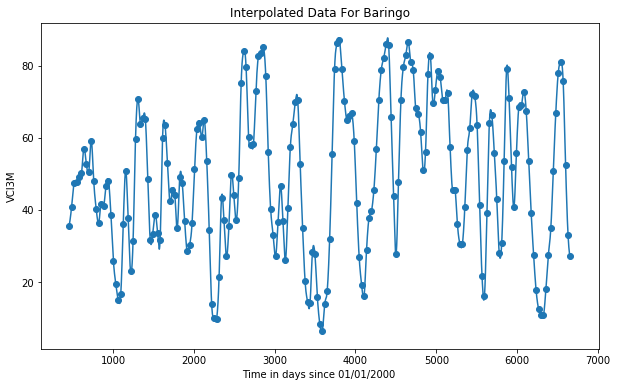

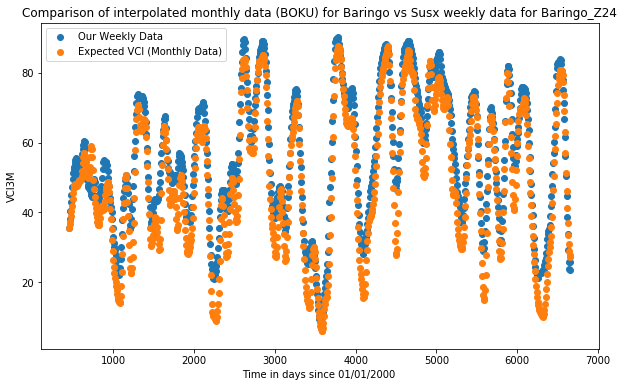

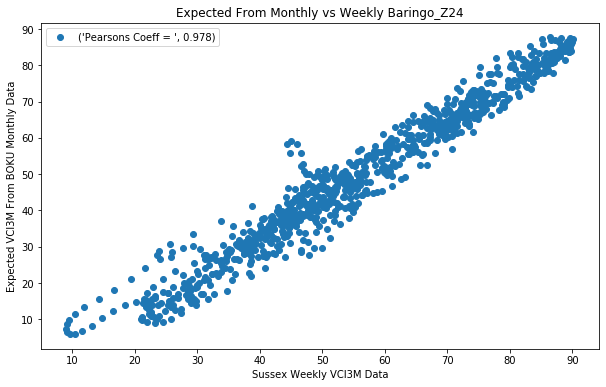

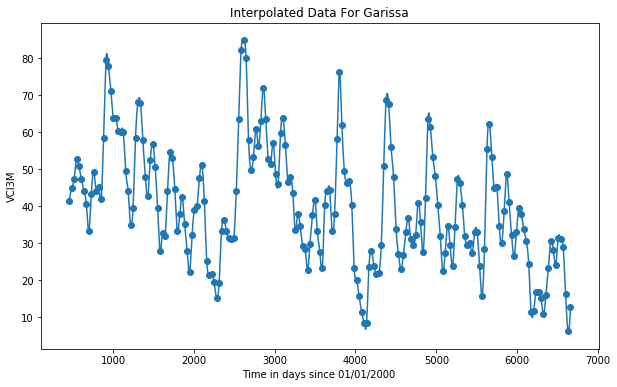

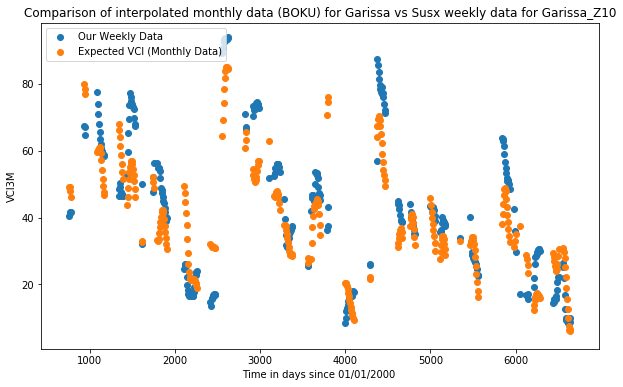

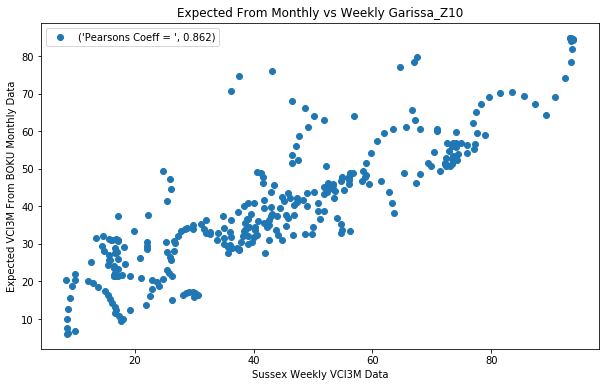

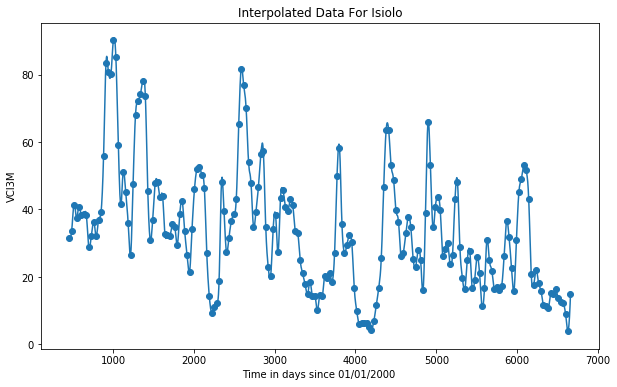

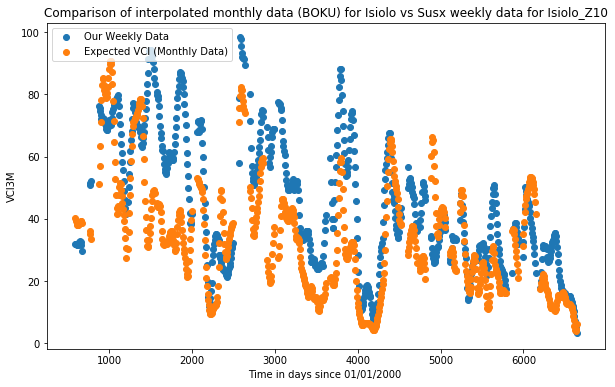

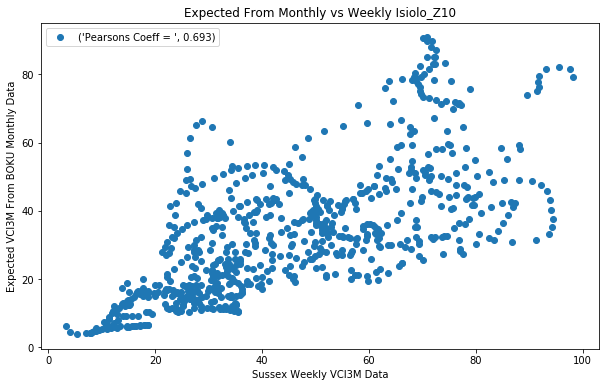

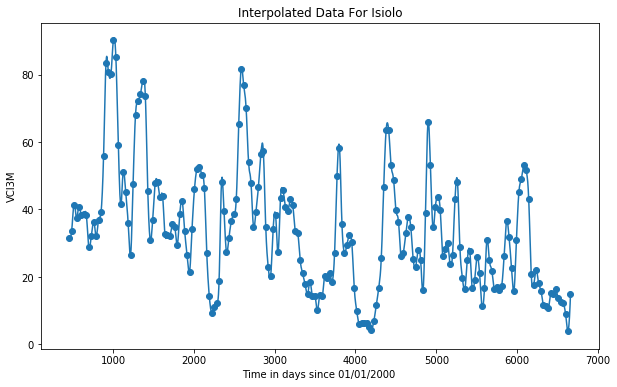

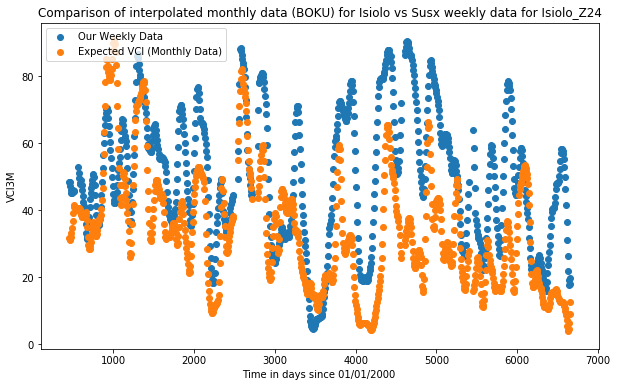

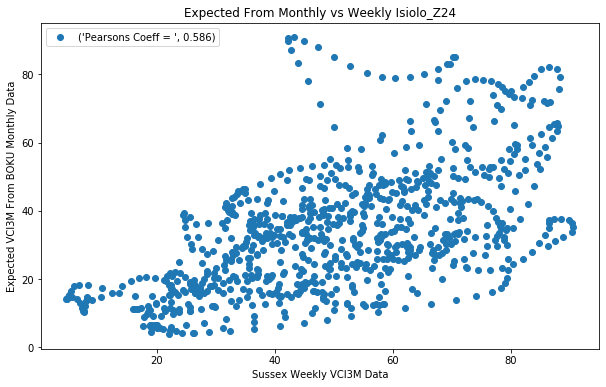

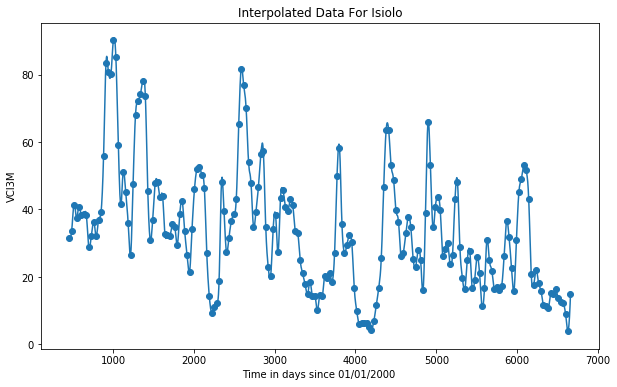

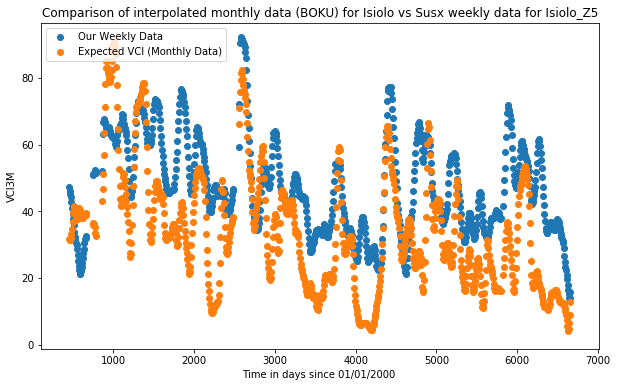

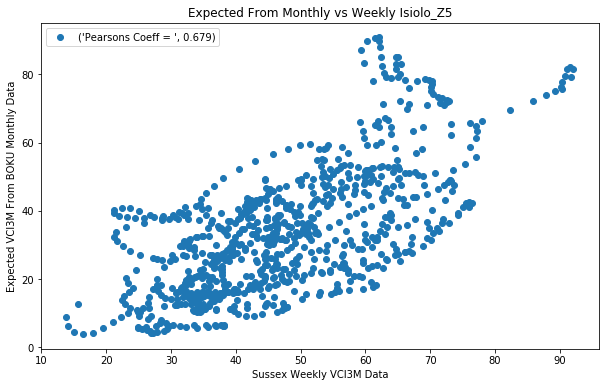

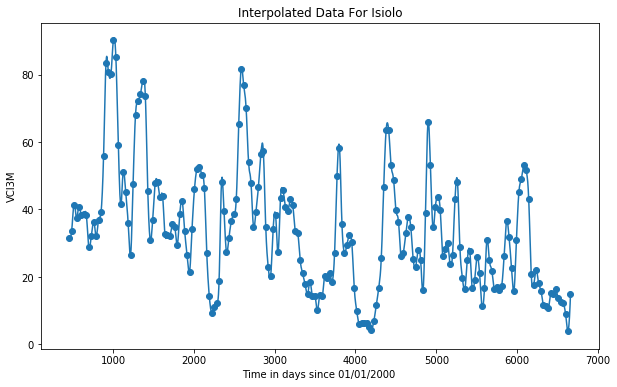

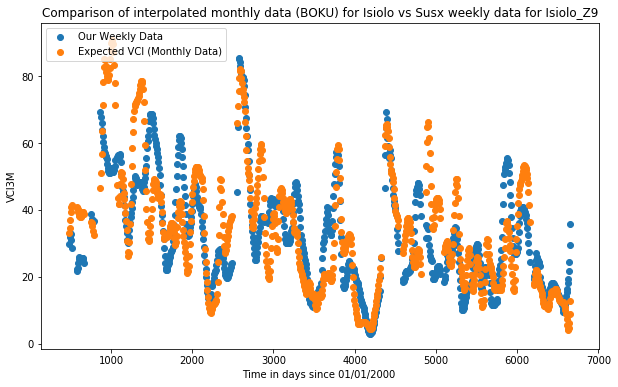

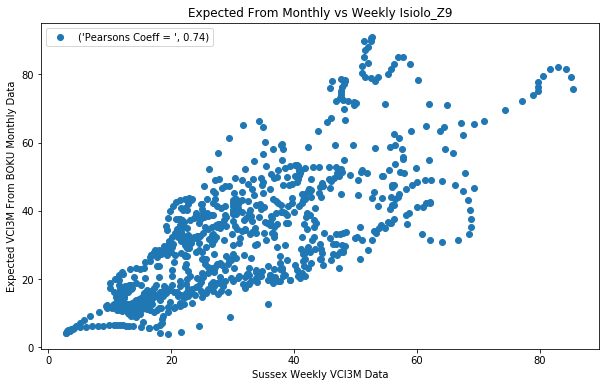

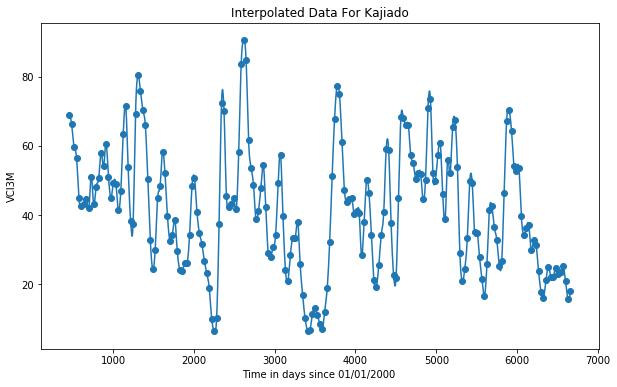

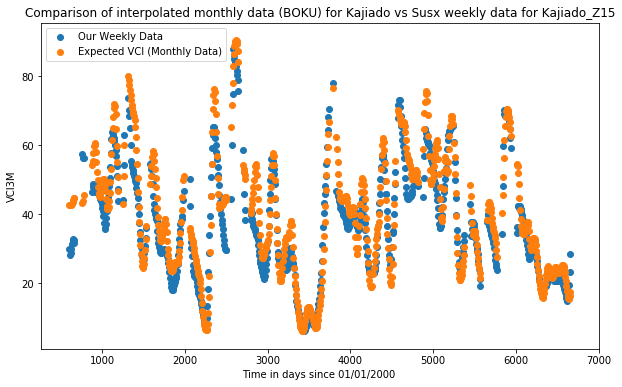

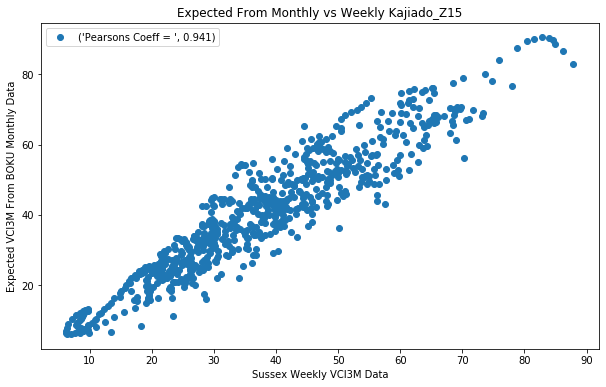

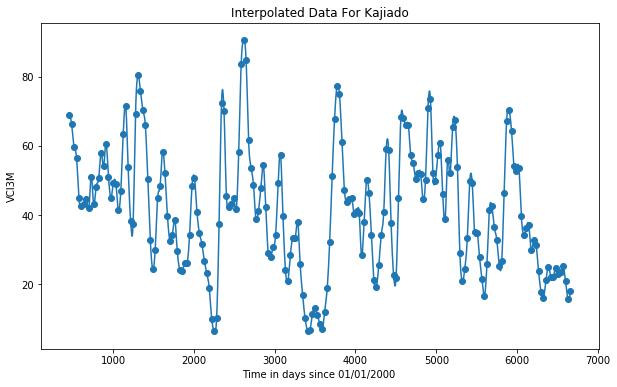

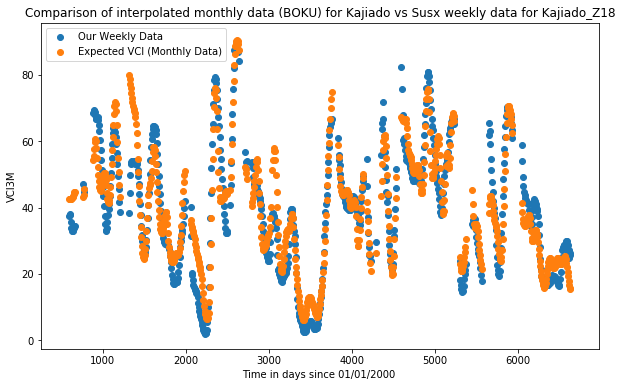

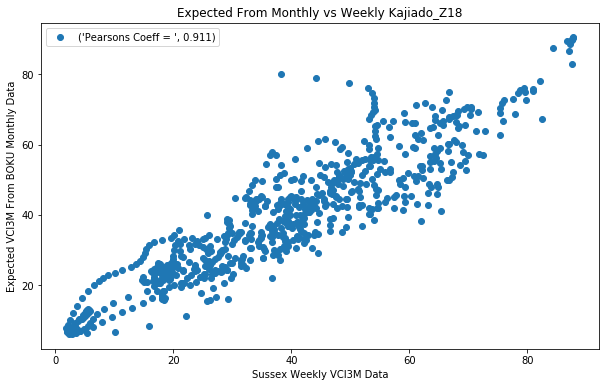

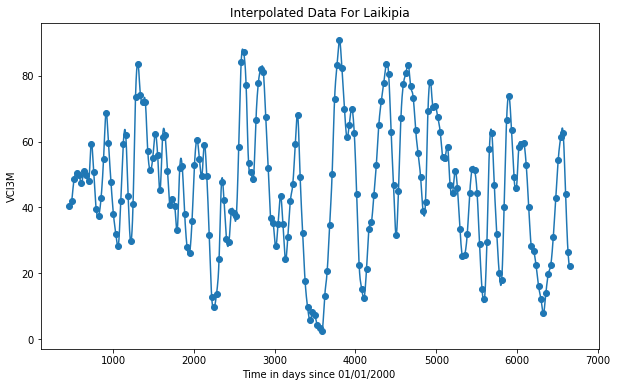

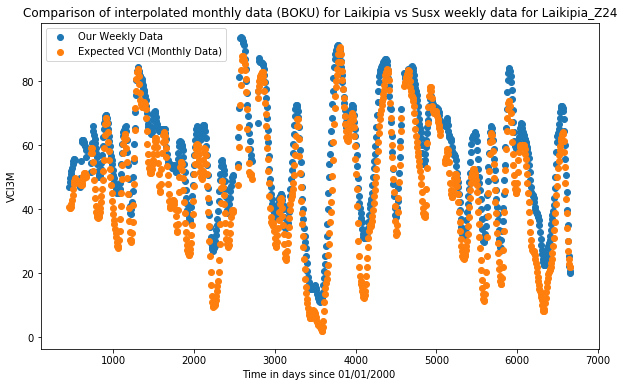

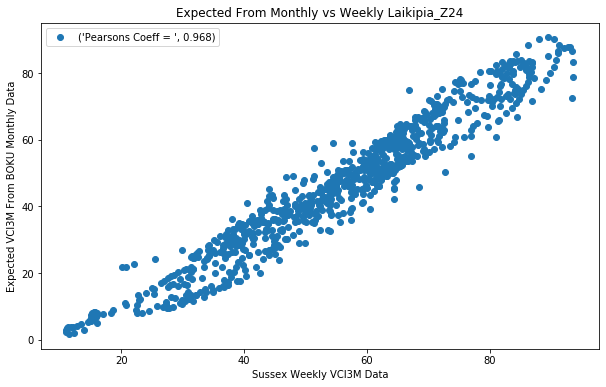

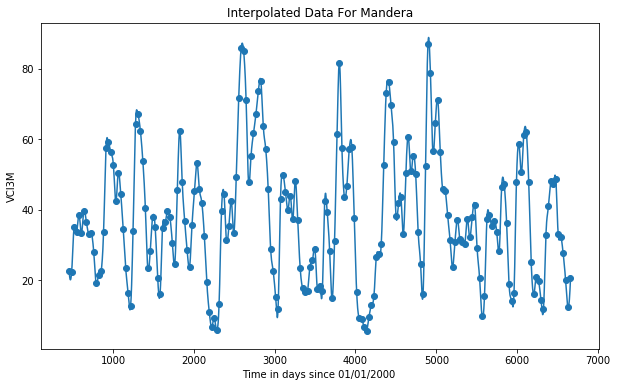

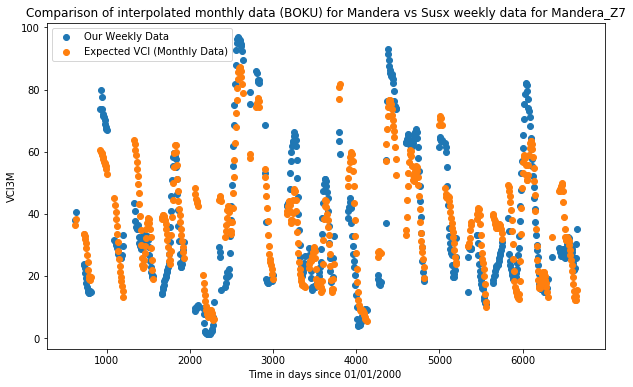

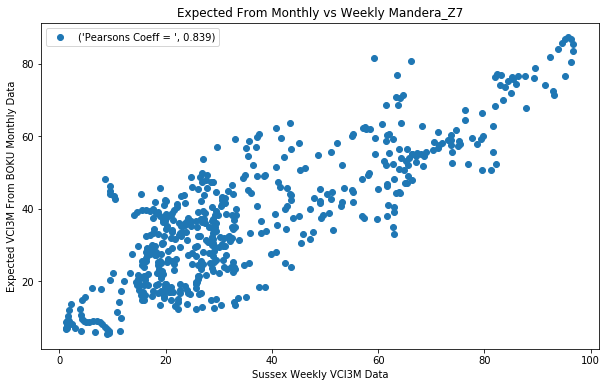

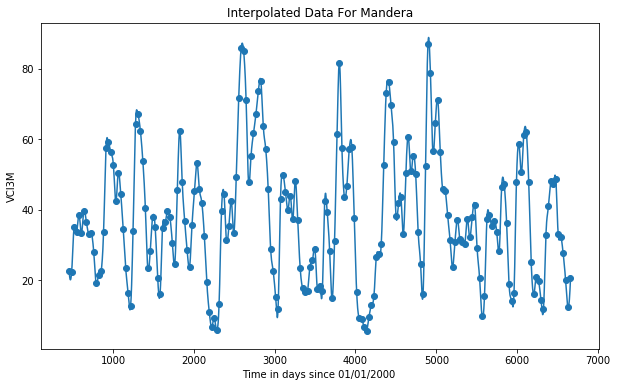

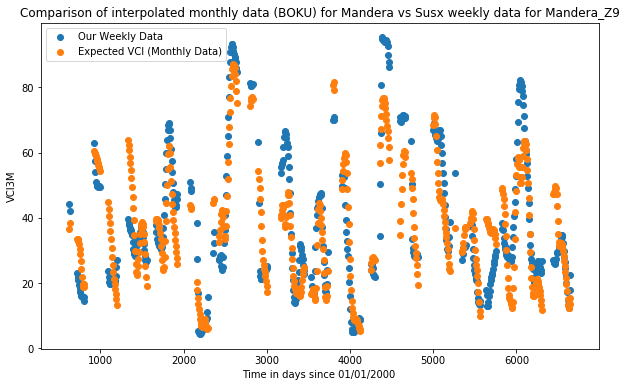

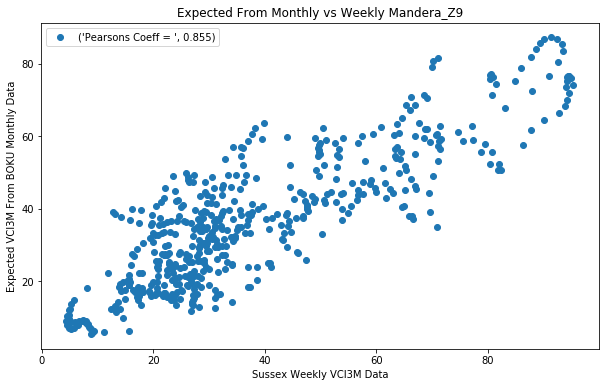

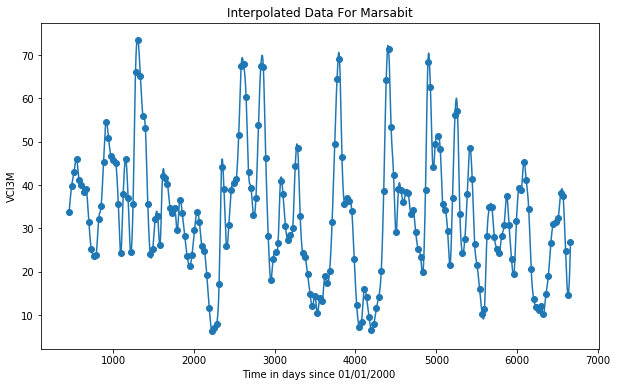

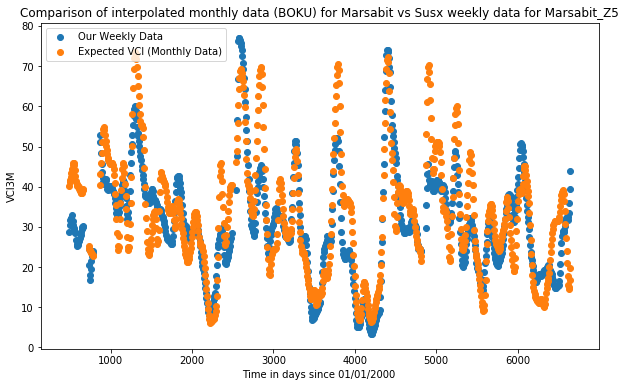

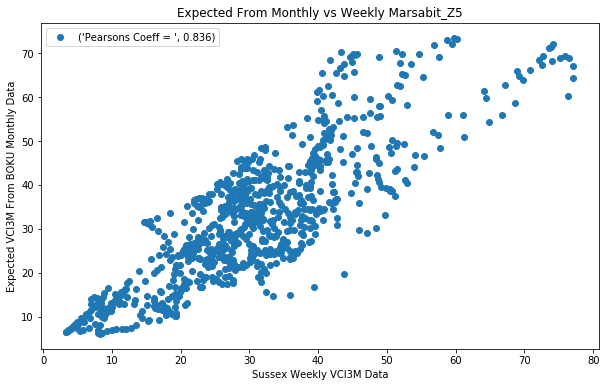

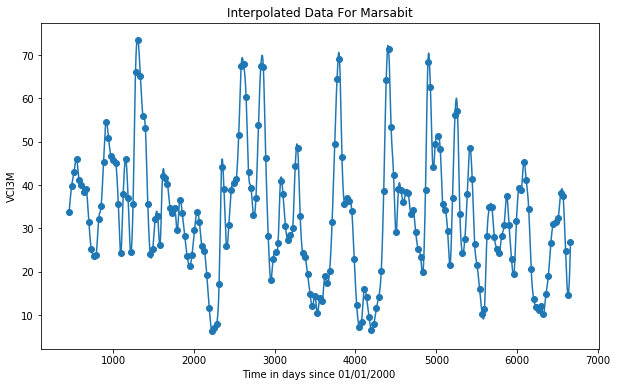

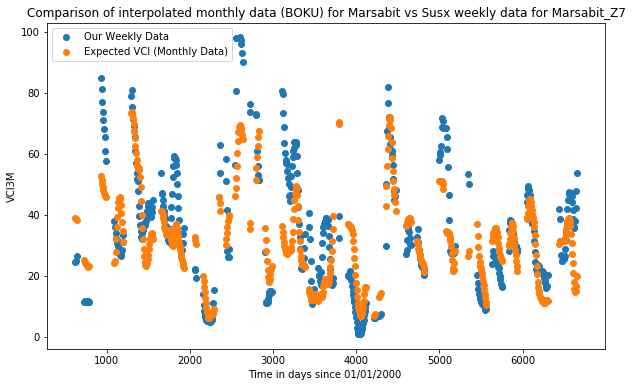

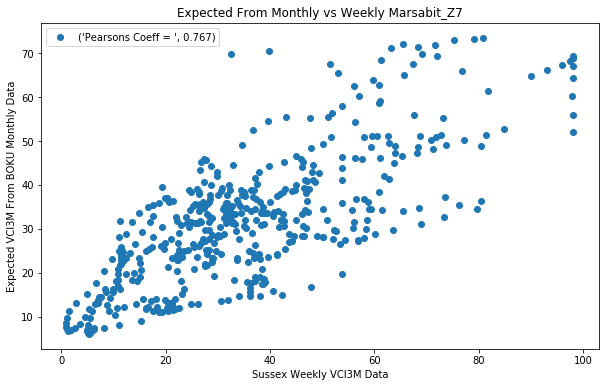

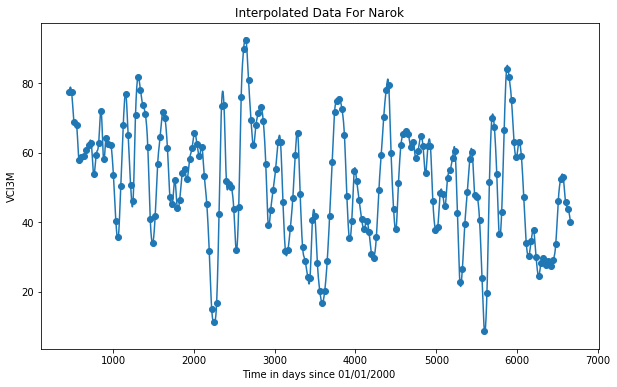

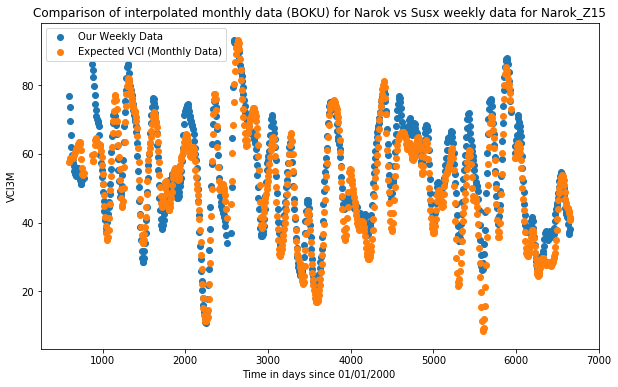

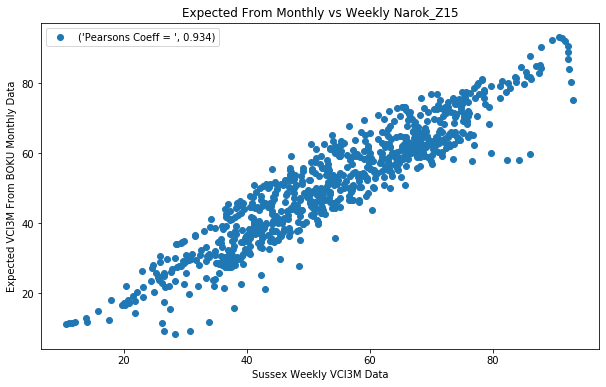

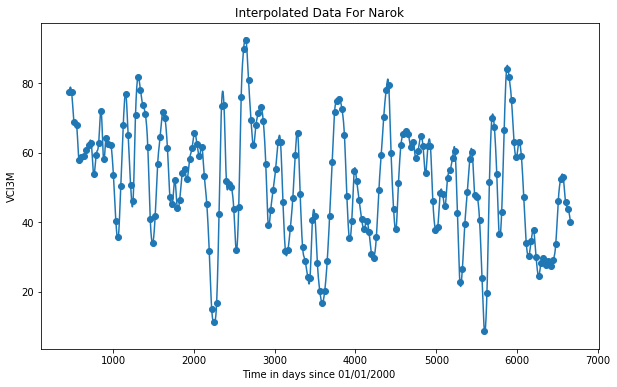

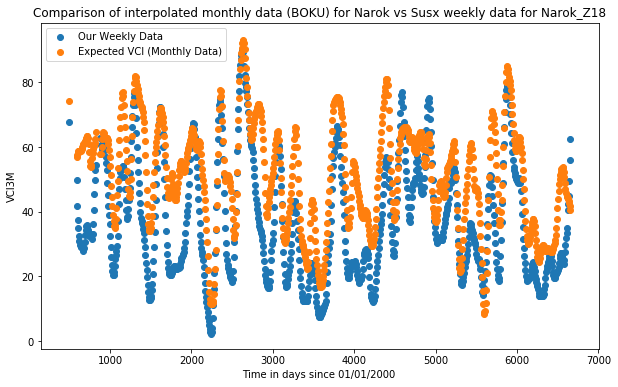

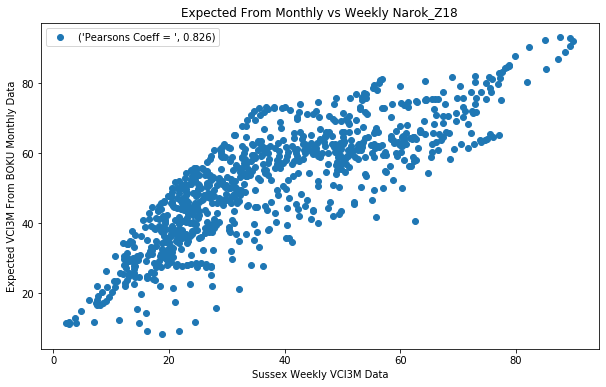

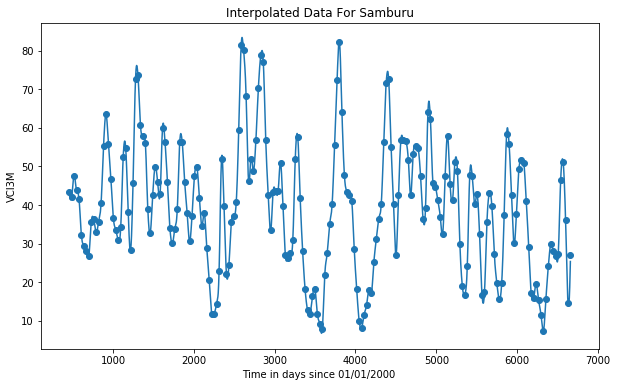

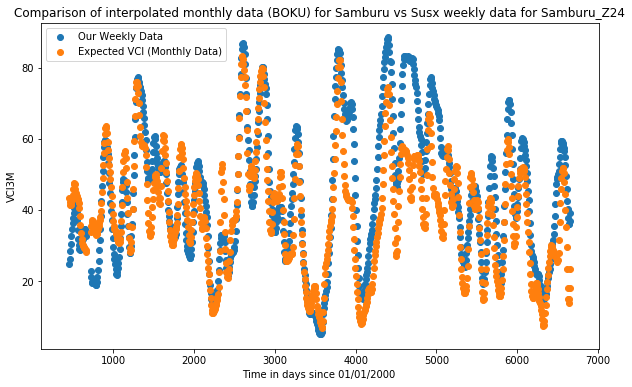

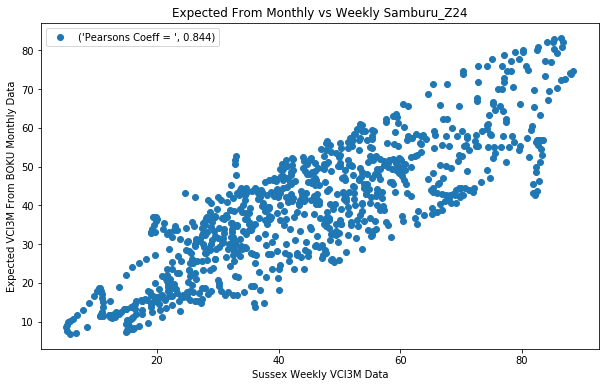

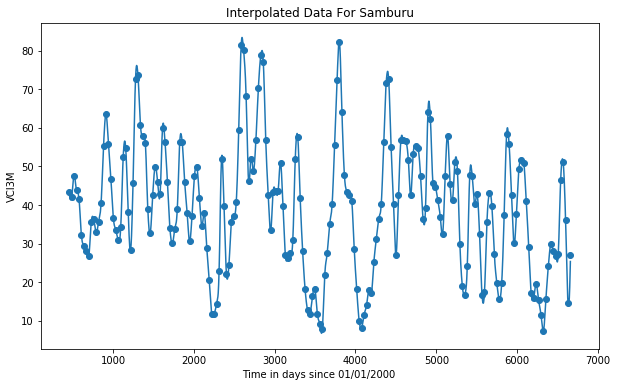

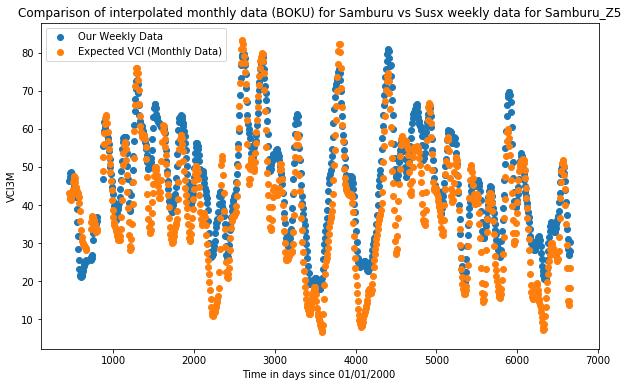

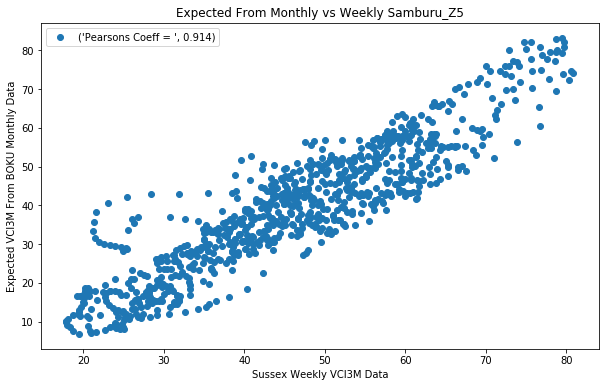

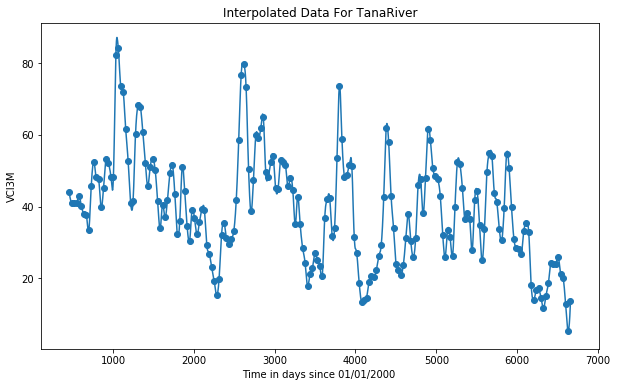

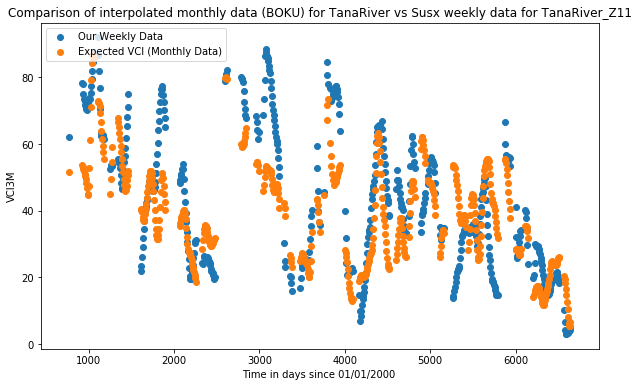

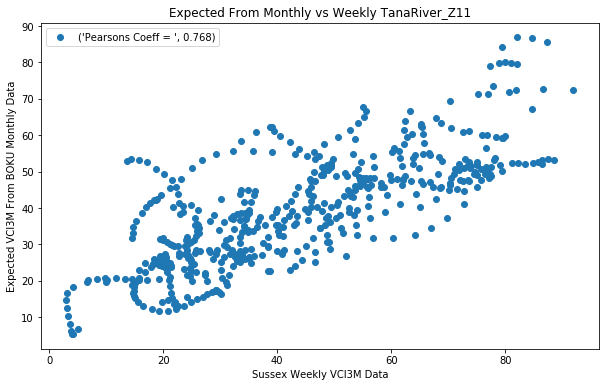

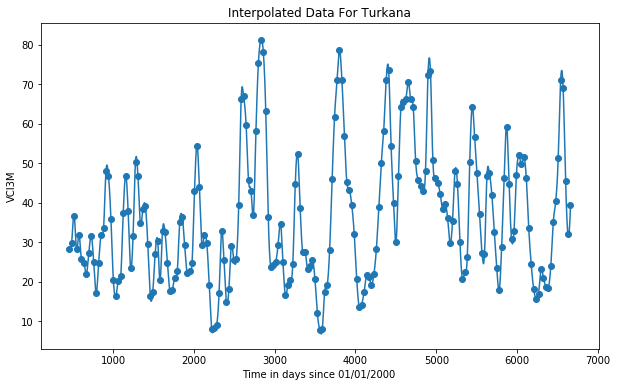

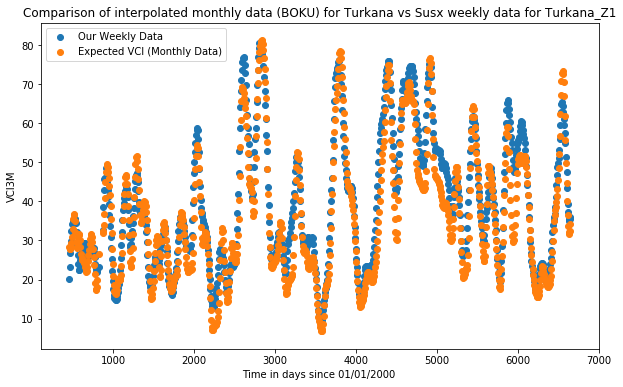

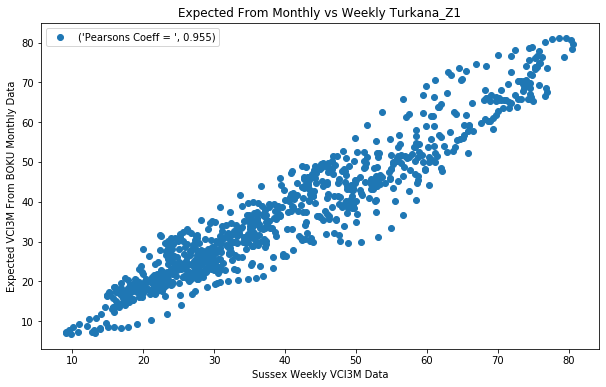

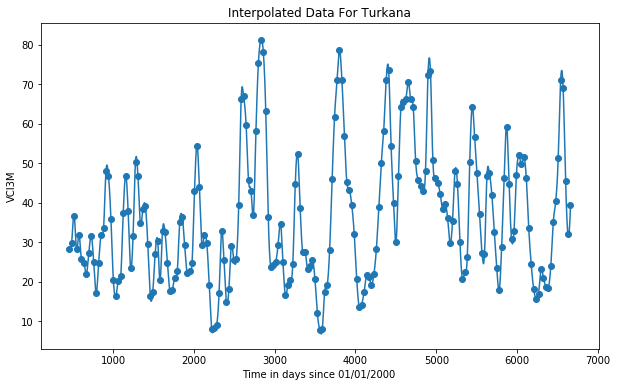

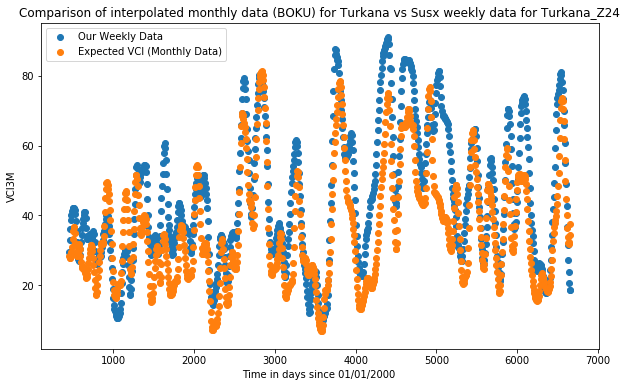

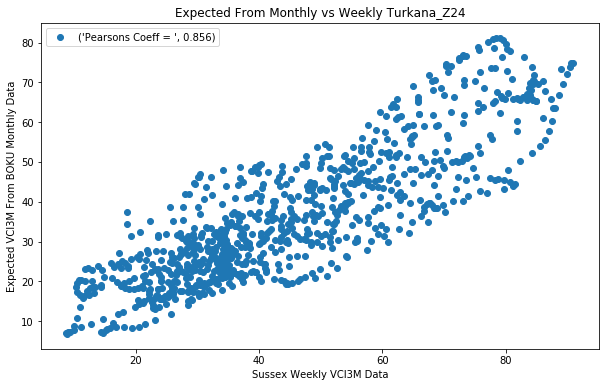

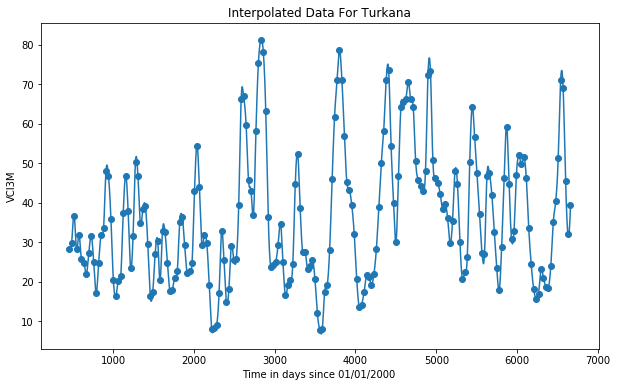

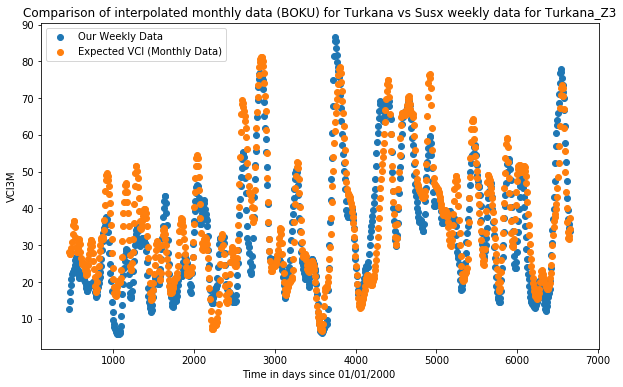

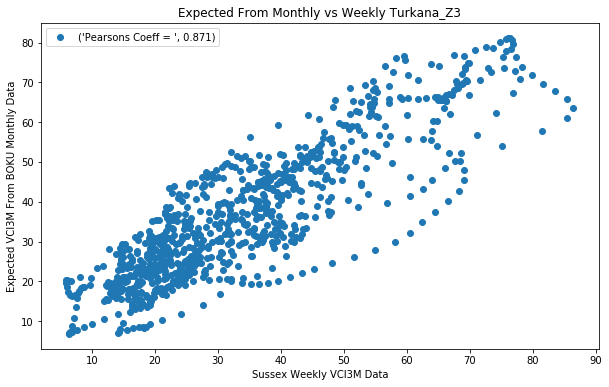

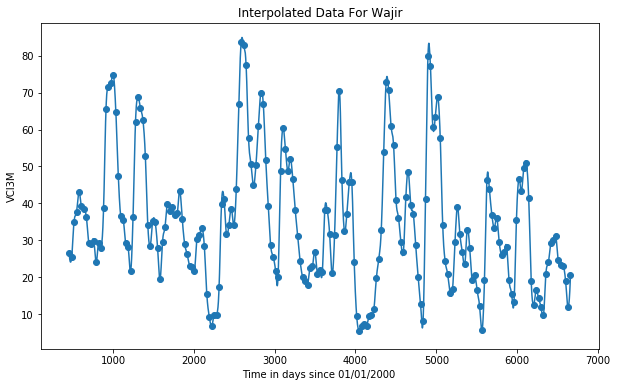

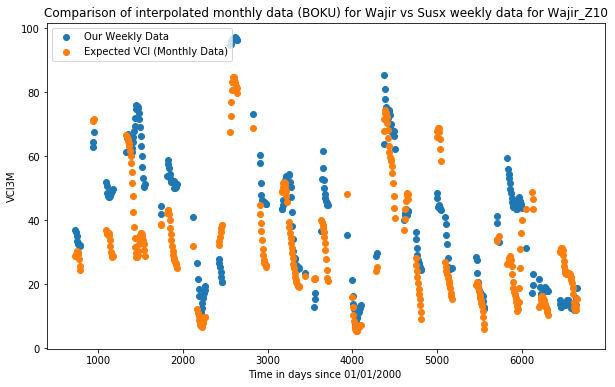

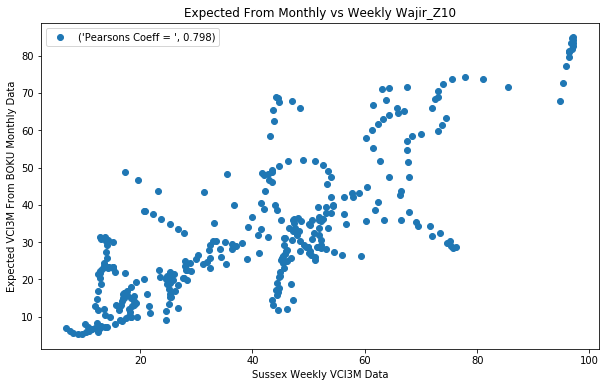

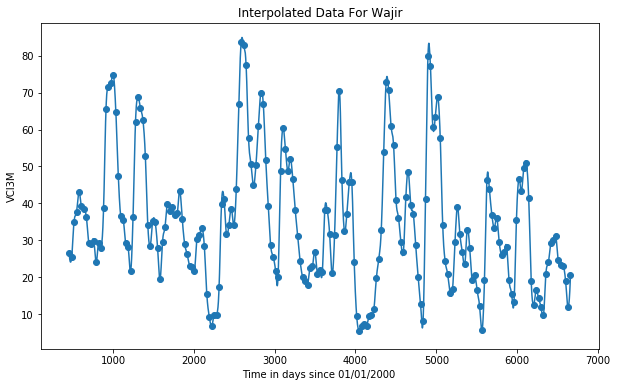

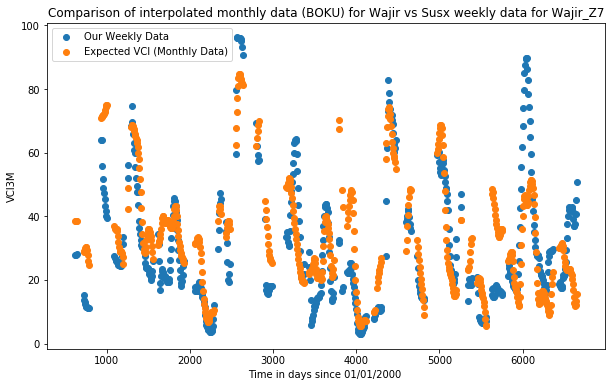

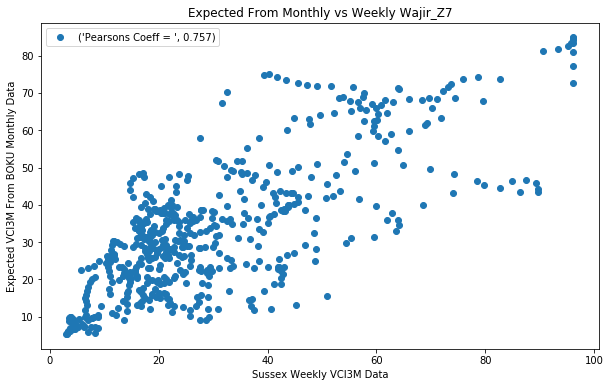

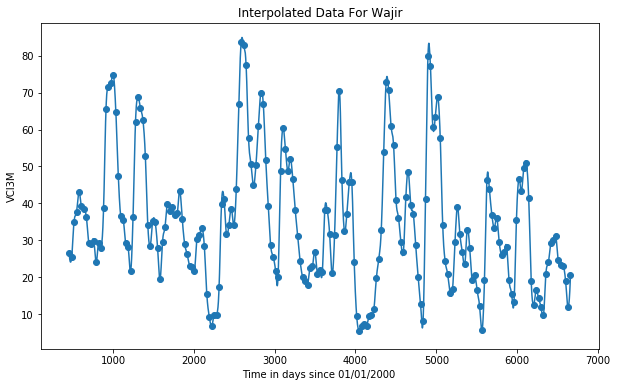

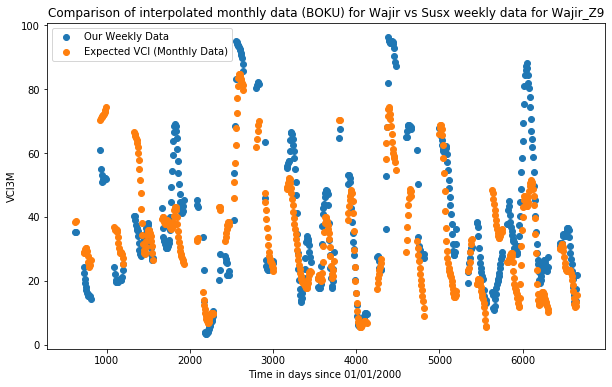

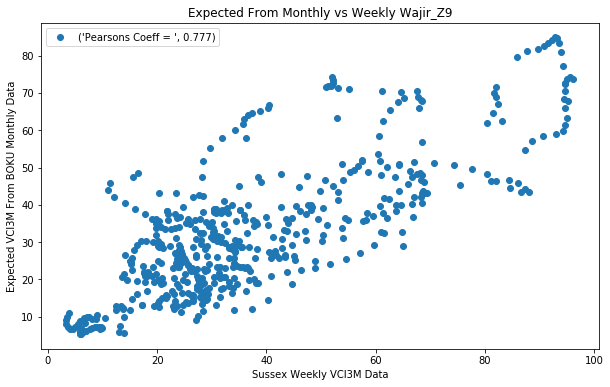

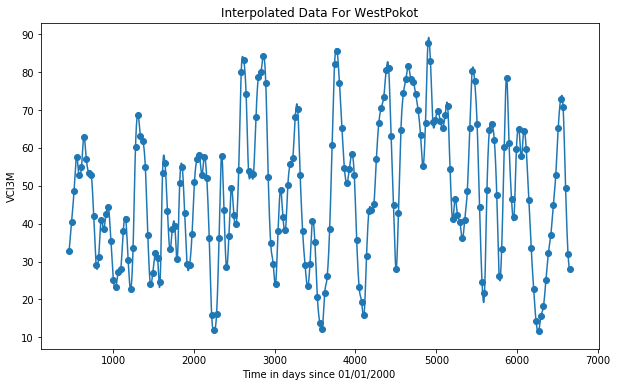

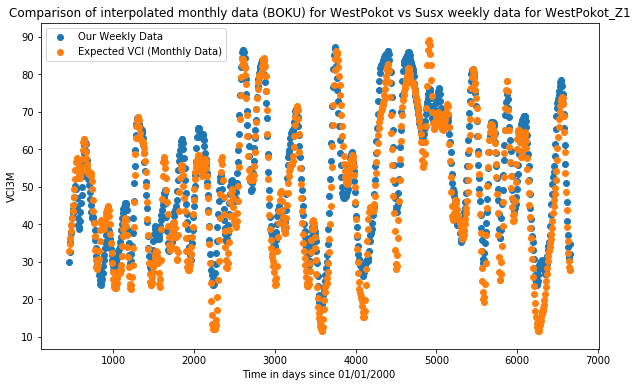

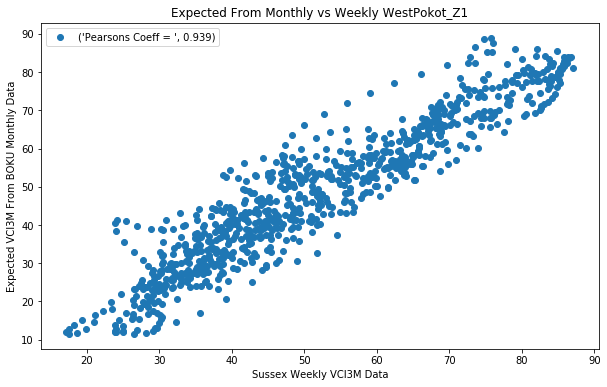

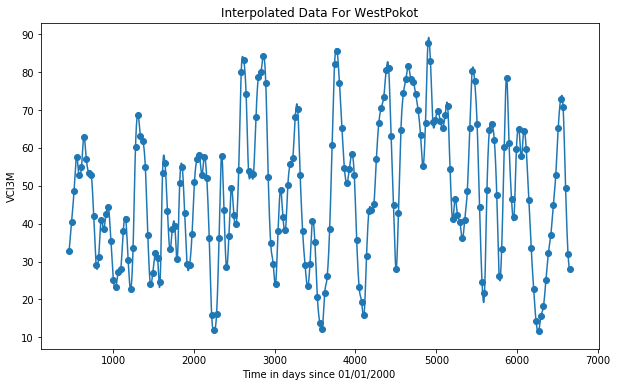

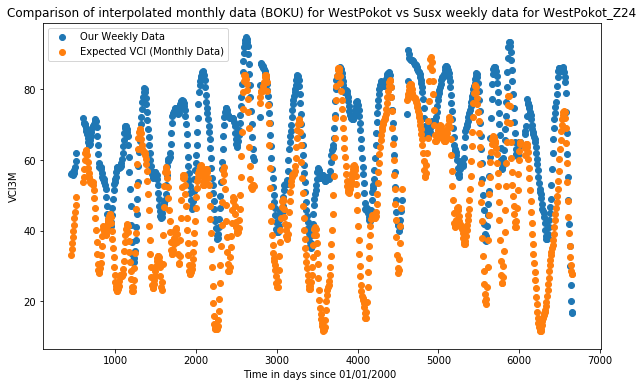

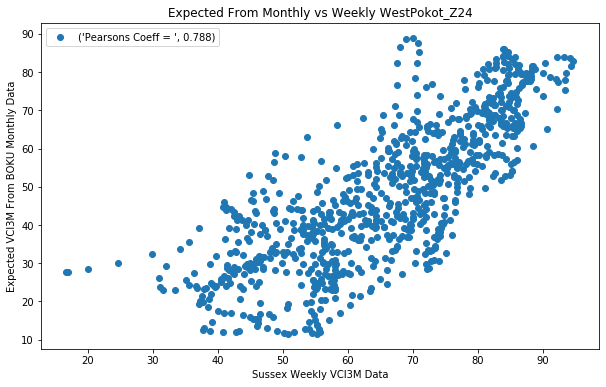

In [2]:

# Creating empty lists to both store data and keep track of the amount of data. 
# While this method may be inefficient it allows for further analysis if needed. 

Pearsons = []
Regions = []
WeekMeans =[]
MonthMeans = []
FracWeekUnder35 = []
FracMonthUnder35 = []
BokuVsSusxU35= []
SusxVsBokuU35 = []
stds = []


# Iterating through every numpy file so the following code works with every possible region.


for file in os.listdir(os.getcwd()+ '/Data/'):
    if file.endswith(".npy"):
        
        # Reading the Sussex Modis weekly Data
        
        Name = file.split('_',1)[0]
        MODIS = np.load(os.getcwd()+'/Data/' + file)
        ModisVci = MODIS[2]
        ModisTime = MODIS[0]

        # Creating empty lists for filtering of nan and region data.
        
        DataVci =[]
        DataTime =[]
        BOKURegionTime=[]
        BOKURegionVCI3M = []
        
        
        # Creating an array of time values to create the interpolation function for. 
        
        xn = np.arange(456,6661,1)
        
        # Matching Sussex npy data to correct data within BOKU CSV data and then creating lists of matching BOKU data.

        for Loc,time,vci in zip(Place,TIME,VCI3M):
            if Loc.upper() == Name.upper():
                BOKURegionTime.append(time)
                BOKURegionVCI3M.append(vci)
                
        # Converting the lists to numpy arrays and removing the first two values. (They are empty nan elements)

        BOKURegionTime = np.array(BOKURegionTime)
        BOKURegionVCI3M = np.array(BOKURegionVCI3M)
        x=BOKURegionTime.astype(float)
        y=BOKURegionVCI3M.astype(float)
        x =np.delete(x,[0,1])
        y =np.delete(y,[0,1])

        # Creating an interpolation function of the BOKU monthly data so Sussex's weekly time series can be fed in. 
        
        NewValues =scipy.interpolate.interp1d(x,y,kind='quadratic')
        
        
        # Plotting the interpolated values over the original series and saving the graphs. 
        
        
        plt.figure(figsize=(10,6))
        plt.plot(xn,NewValues(xn))
        plt.xlabel('Time in days since 01/01/2000 ')
        plt.ylabel('VCI3M')
        plt.title('Interpolated Data For '+ Name)
        plt.scatter(x,y)
        plt.savefig((os.getcwd()+'/pics/InterpolatedDataFor'+ Name+'.png'))
        plt.show()
        
        # Creating more empty lists so that the data can be filtered into several different categories 

        WeekUnder35 =[]
        MonthUnder35=[]   
        Boku2 =[]
        Susx2 = []
        BokuU35=[]
        SusxU35 =[]
        
        
        # Filtering out any nan values as well as creating a list of any sussex VCI data below 35.
        
        for a,b in zip(ModisVci,ModisTime):
            if np.isnan(a) == False and b >= 456 and b <= 6661 and a <35:
                DataVci.append(a)
                DataTime.append(b)
                WeekUnder35.append(a)
            elif np.isnan(a) == False and b >= 456 and b <= 6661 and a >= 35:
                DataVci.append(a)
                DataTime.append(b)
        
        
        # Creating a new series based on interpolated monthly data using the exact time of Sussex's weekly readings. 
        
        Compare = NewValues(DataTime)
     
        # Now if any VCI3M values are under 35 they are added to lists along with the matching data from the other institution
        
        for item,item2 in zip(Compare,DataVci):
            if item < 35:
                MonthUnder35.append(item)
                Boku2.append(item)
                Susx2.append(item2)
            if item2 <35:
                BokuU35.append(item)
                SusxU35.append(item2)
                
        # These lists are then analysed. For example, if BOKU is under 35 and Sussex is too then a counter is increased.
        # This will allow me to obtain a percentage of time the data is matching for when in a drought period. 
                
        U35Counter = 0
        for item in BokuU35:
            if item <35:
                U35Counter +=1
        U35Counter2 = 0
        for item in Susx2:
            if item <35:
                U35Counter2 +=1
                
    
        # Saving fraction of both in drought and fraction of time in drought to list so it can be displayed and saved later
        
        SusxVsBokuU35.append(U35Counter2/len(Boku2))
        BokuVsSusxU35.append(U35Counter/len(SusxU35))        
        
        FracWeekUnder35.append(len(WeekUnder35)/len(DataVci))       
        FracMonthUnder35.append(len(MonthUnder35)/len(Compare))
        
        
        # Plotting Sussex's weekly data on top of the interpolated monthly data and saving it. 
        
        plt.figure(figsize=(10,6))       
        plt.scatter(DataTime,DataVci,label='Our Weekly Data')
        plt.scatter(DataTime,Compare,label='Expected VCI (Monthly Data)')
        plt.title('Comparison of interpolated monthly data (BOKU) for '+ Name+' vs Susx weekly data for ' + file.split('_AR_MODIS',1)[0])
        plt.xlabel('Time in days since 01/01/2000 ')
        plt.ylabel('VCI3M')
        plt.legend(loc='upper left')
        plt.savefig((os.getcwd()+'/pics/Comparison'+ file.split('_AR_MODIS',1)[0] +'.png'))
        plt.show()
        
        
        # Calculting the Pearson coeff between the two datasets
        
        Pearson = np.corrcoef(Compare,DataVci)
        Pearson = round(Pearson[0,1],3)
        
        # Plotting the BOKU interpolated data against the sussex weekly data
        
        plt.figure(figsize=(10,6)) 
        plt.title('Expected From Monthly vs Weekly ' + (file.split('_AR_MODIS',1)[0]))
        plt.xlabel('Sussex Weekly VCI3M Data')
        plt.ylabel('Expected VCI3M From BOKU Monthly Data')
        plt.scatter(DataVci,Compare,label = ('Pearsons Coeff = ', Pearson))
        plt.legend(loc='upper left')     
        plt.savefig((os.getcwd()+'/pics/BOKUInterpvsSusx'+ file.split('_AR_MODIS',1)[0] +'.png'))
        plt.plot()
        plt.show()
        
        # Calculating the mean,standard deviation and accompanying region of both data sets and then saving them to lists to be displayed and saved later.
        
        MonthMean = np.mean(Compare)
        WeekMean = np.mean(DataVci)
        std = np.round(np.std(Compare-DataVci),3)
        stds.append(std)
        MonthMeans.append(round(MonthMean,3))
        WeekMeans.append(round(WeekMean,3))

        Pearsons.append(Pearson)
        Regions.append((file.split('_AR_MODIS',1)[0])+ ' vs '+ Name)
        
    
        

### <center>Outputting statistical test to CSV and table within notebook </center>

In [3]:
OUT_DIR = (os.getcwd()+'/pics')

# Calculating the difference in means

difference = np.array(MonthMeans)-np.array(WeekMeans)

# Creating and filling table

t = Table([Regions, Pearsons,MonthMeans,WeekMeans,np.round(difference,3),stds,np.round(FracWeekUnder35,3),
           np.round(np.array(FracWeekUnder35)*100,3),np.round(FracMonthUnder35,3),np.round(np.array(FracMonthUnder35)*100,3),
           np.round(np.array(BokuVsSusxU35)*100,3),np.round(np.array(SusxVsBokuU35)*100,3)], 
          names=('Region', 'Pearsons Coeff','BOKU Interp Mean', 'Sussex Mean','Difference In mean(Boku Interp-Sussex)',
                 'Standard Dev (BOKU - Sussex)','Fraction Of Time <35 VCI Sussex','Percentage of time Sussex',
                 'BOKU Frac Of time <35 VCI','Percentage of time BOKU','Percentage Of BOKU < 35 when Sussex <35',
                 'Percentage of time Sussex < 35 when BOKU < 35'), meta={'name': 'Interp'})

# Creating averages row for table.

t.add_row(['Averages',np.round(np.mean(Pearsons),3),np.round(np.mean(MonthMeans),3),np.round(np.mean(WeekMeans),3),
           np.round(np.mean(difference),3),np.mean(stds),np.round(np.mean(FracWeekUnder35),3),
           np.round(np.mean(FracWeekUnder35)*100,3),np.round(np.mean(FracMonthUnder35),3),
           np.round(np.mean(FracMonthUnder35)*100,3),np.round(np.mean(BokuVsSusxU35)*100,3),
           np.round(np.mean(SusxVsBokuU35)*100,3)])

# Saving table to CSV file and then displaying it.

t.write(("{}/" +'StatisticalTestsInterp.csv').format(OUT_DIR), overwrite=True)
t.show_in_notebook()

### <center> Comparing by removing extra Sussex weekly points </center>

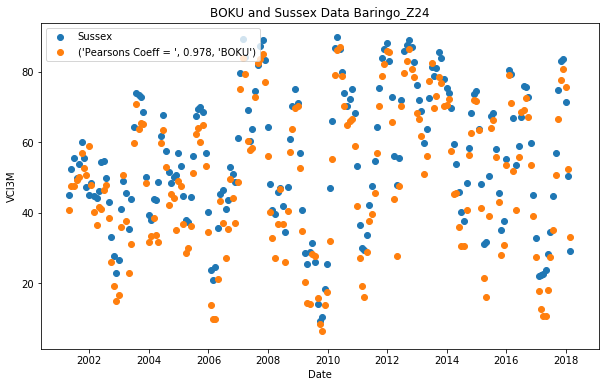

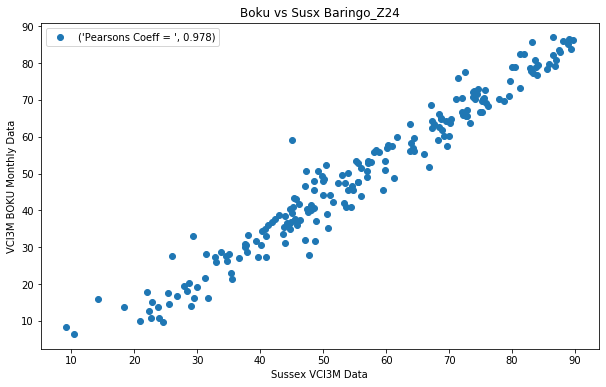

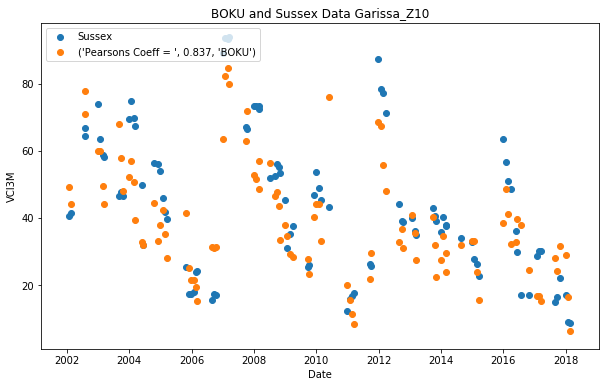

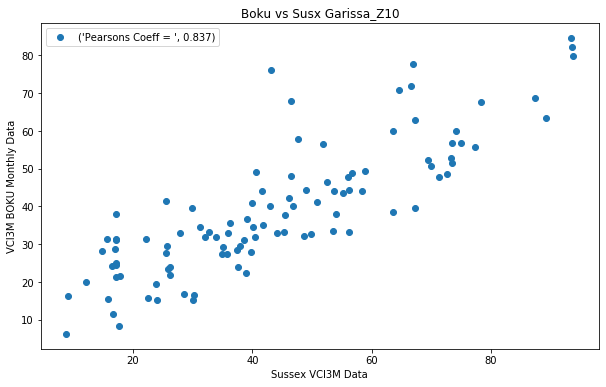

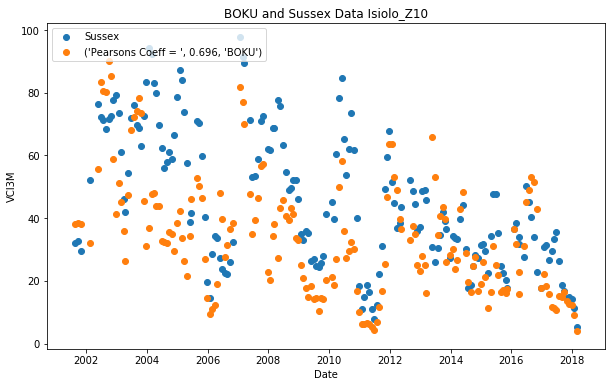

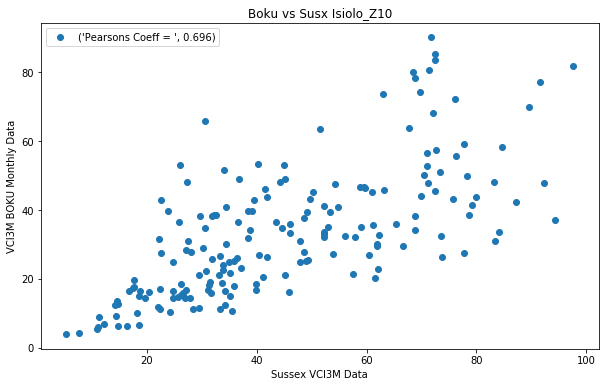

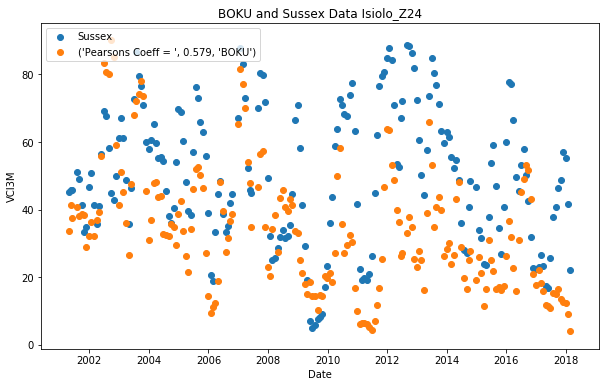

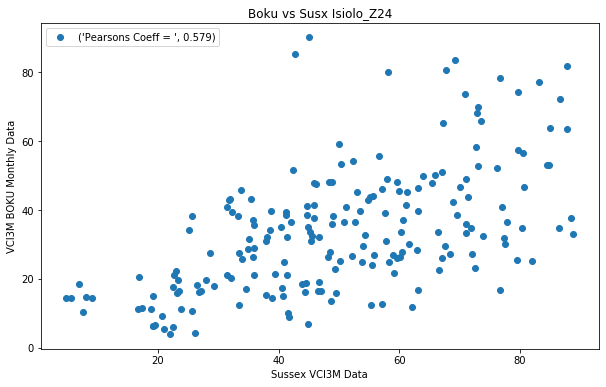

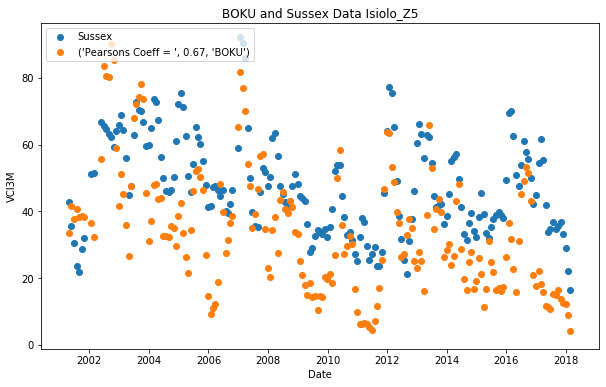

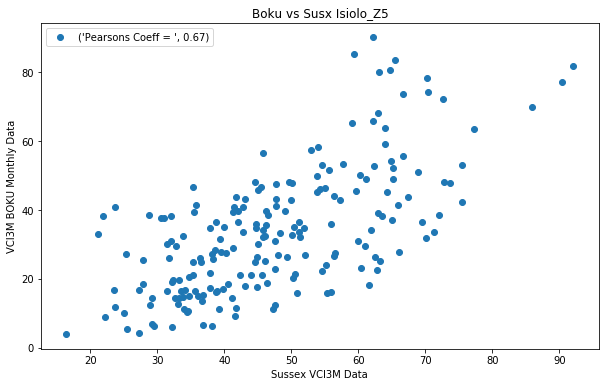

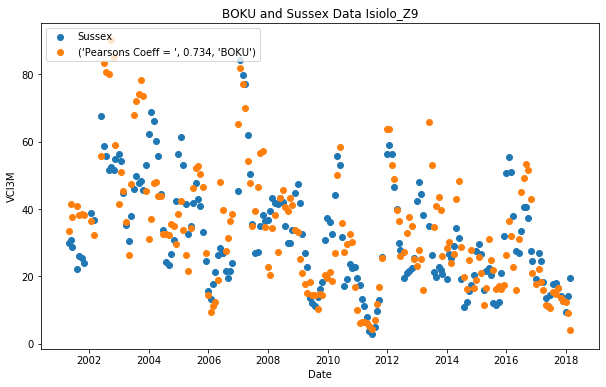

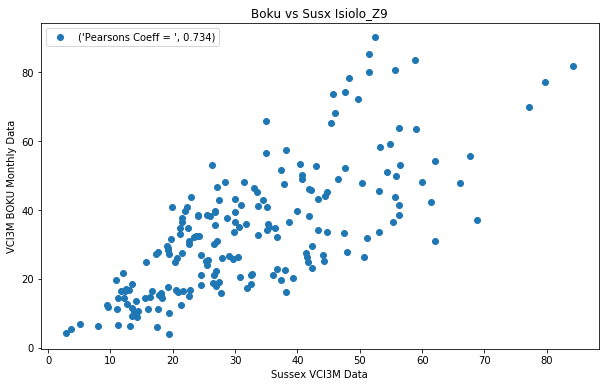

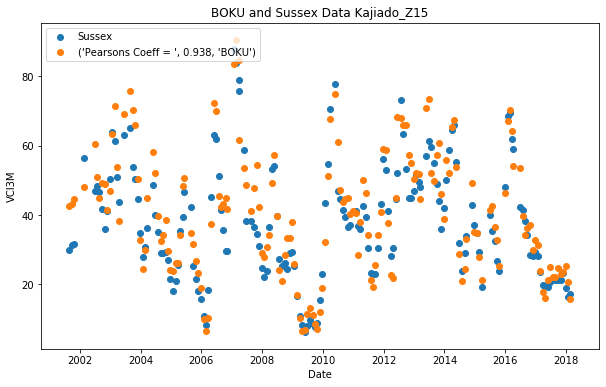

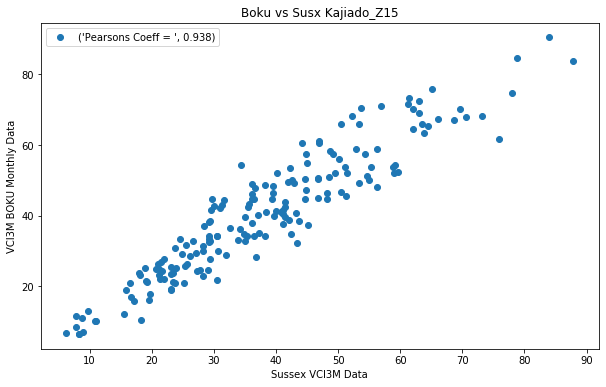

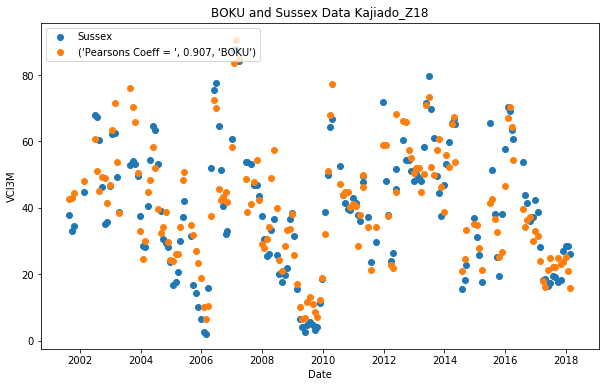

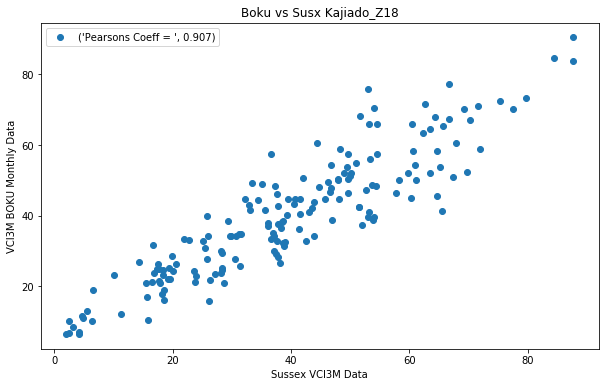

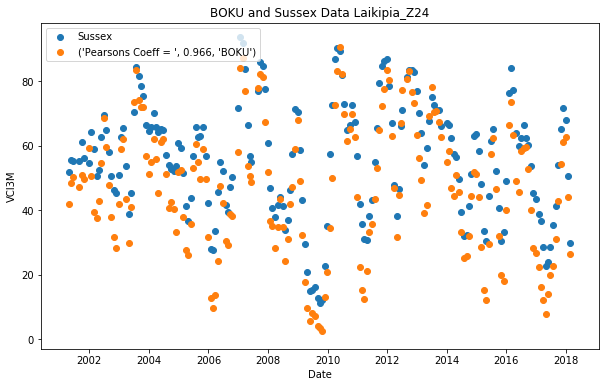

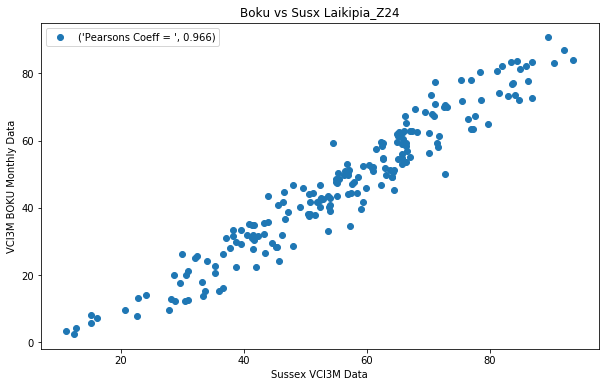

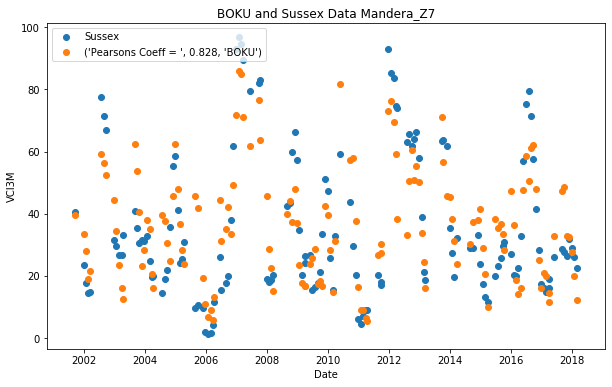

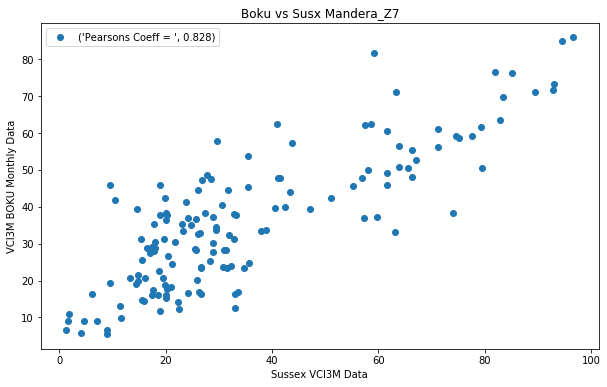

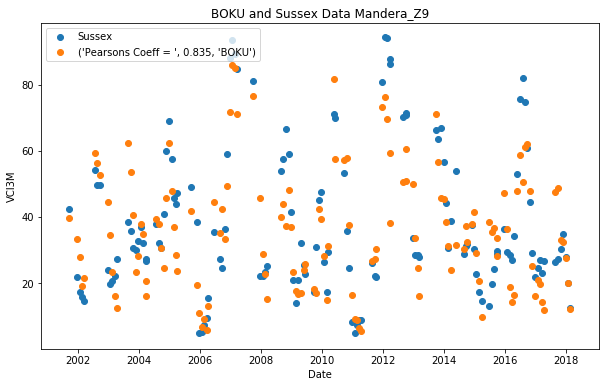

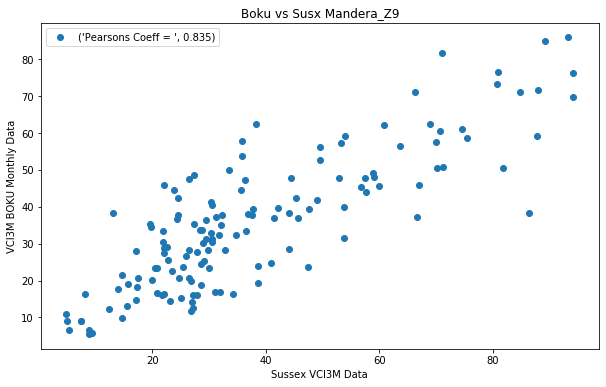

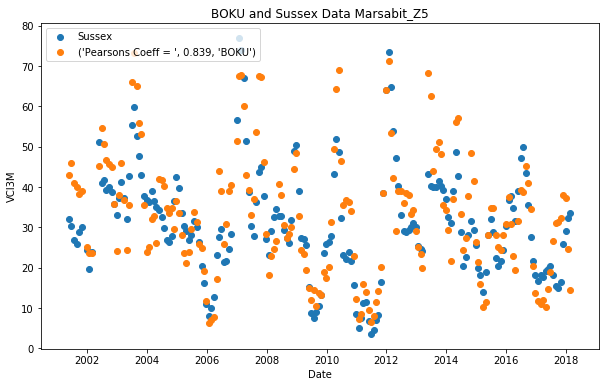

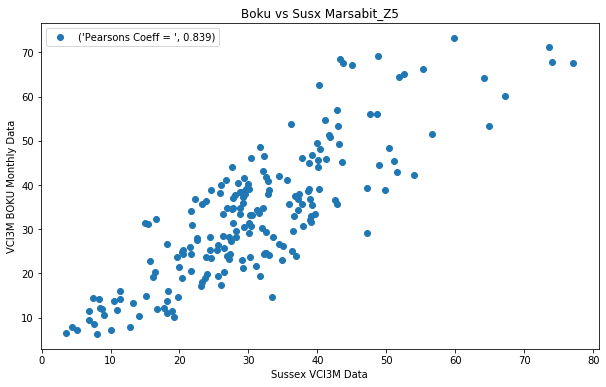

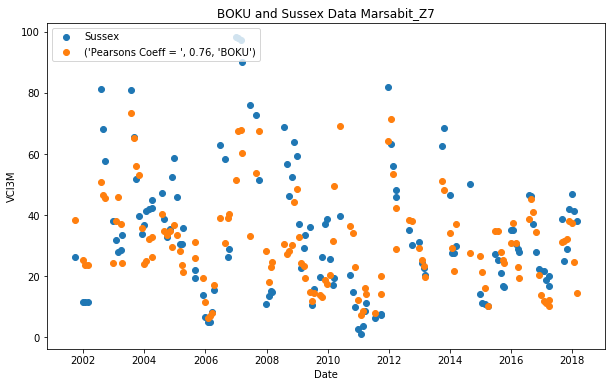

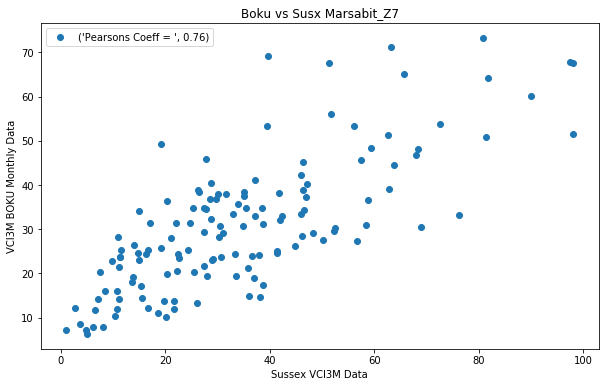

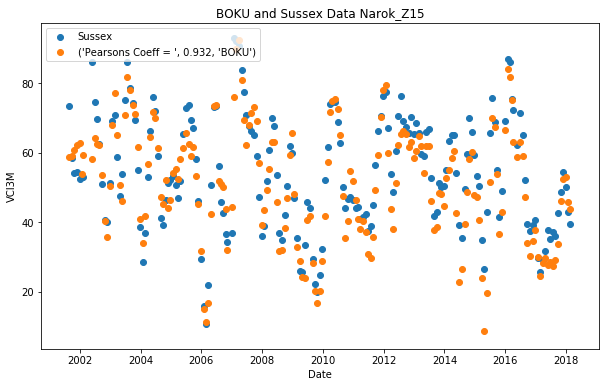

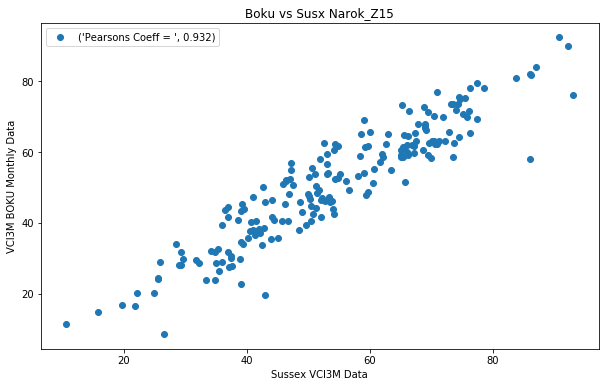

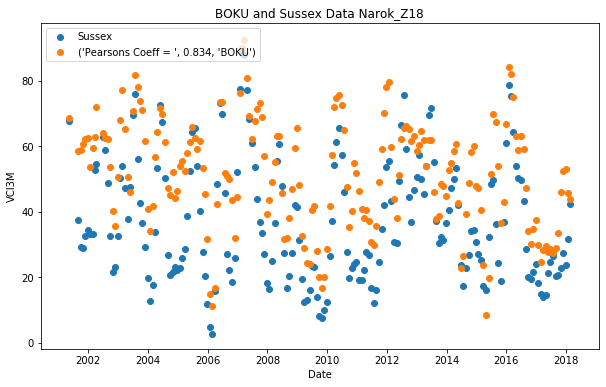

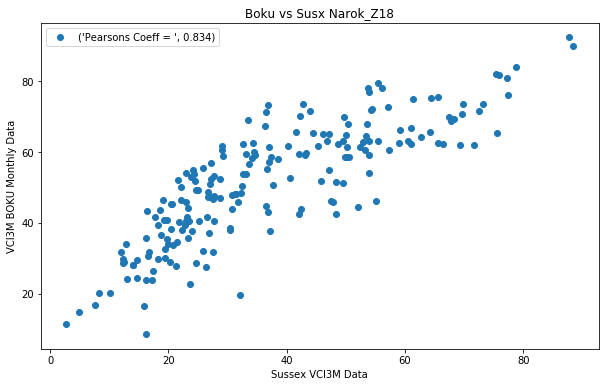

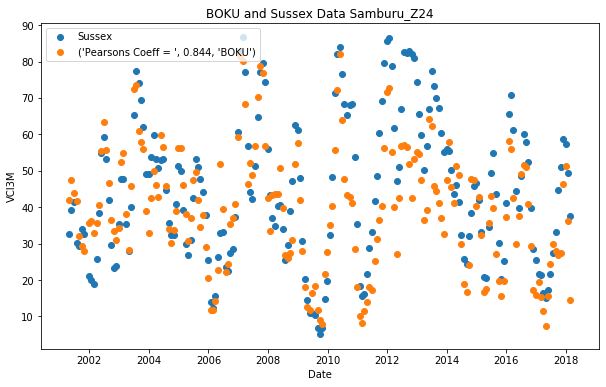

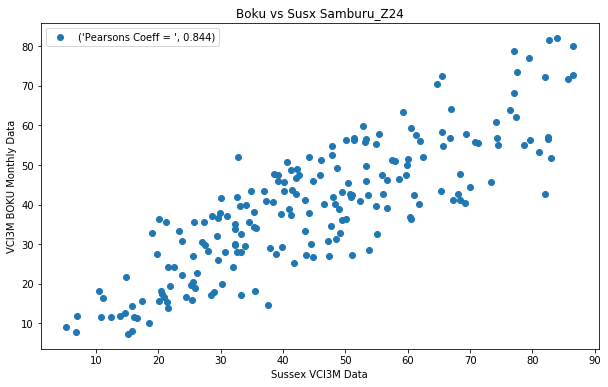

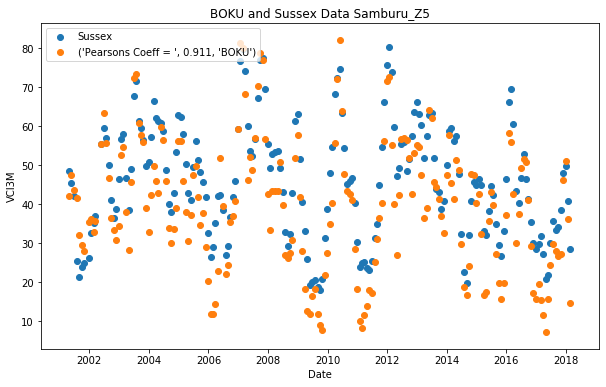

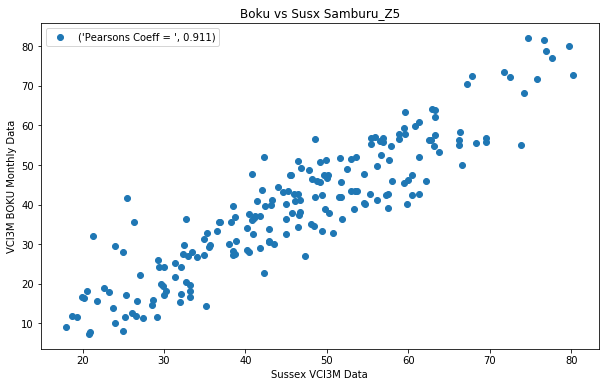

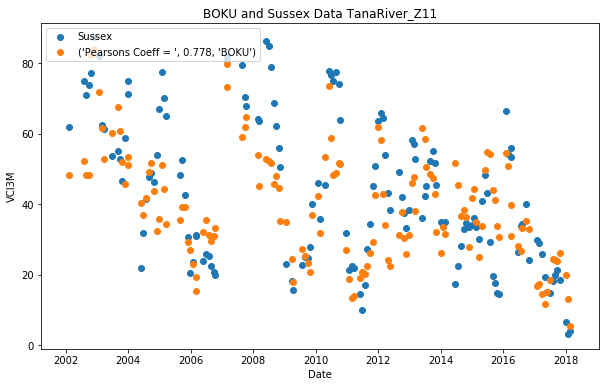

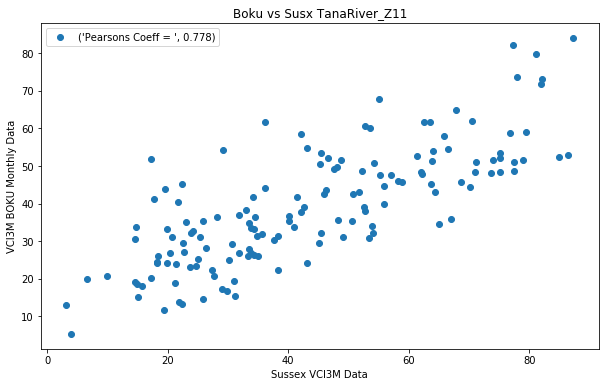

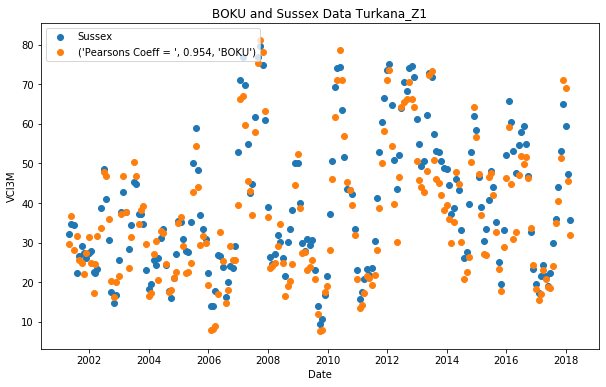

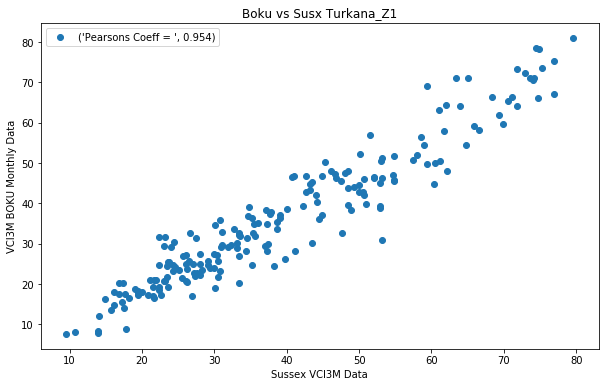

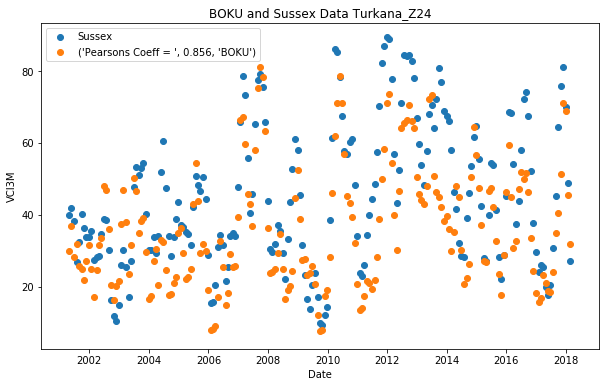

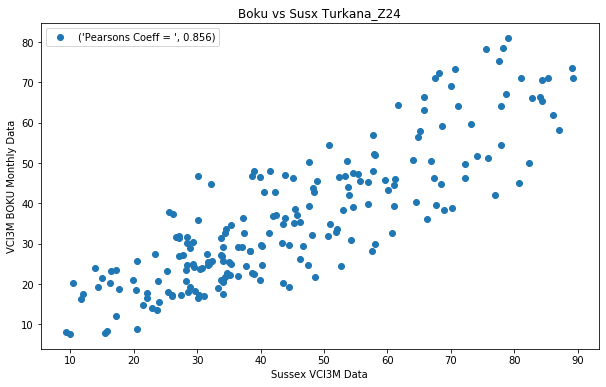

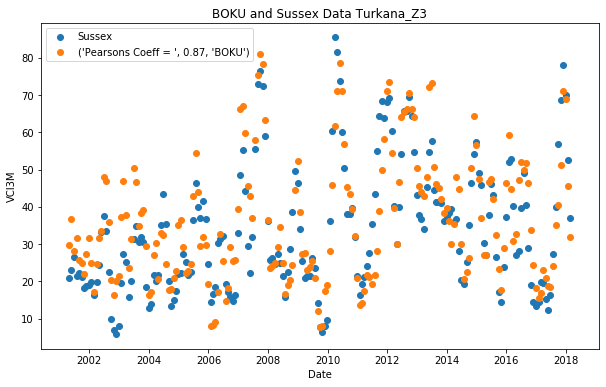

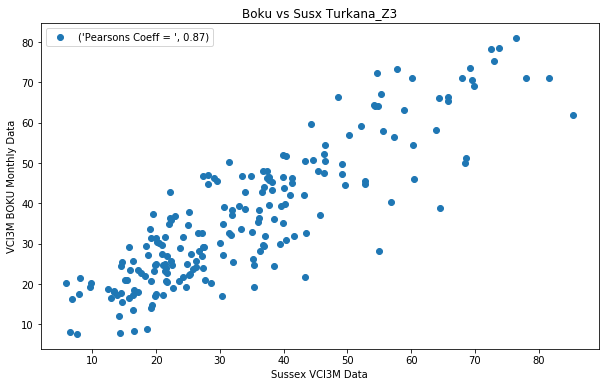

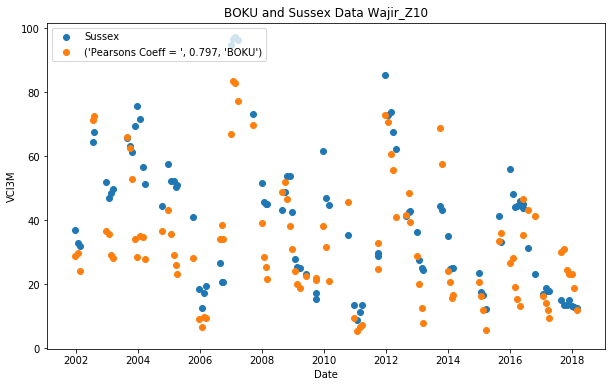

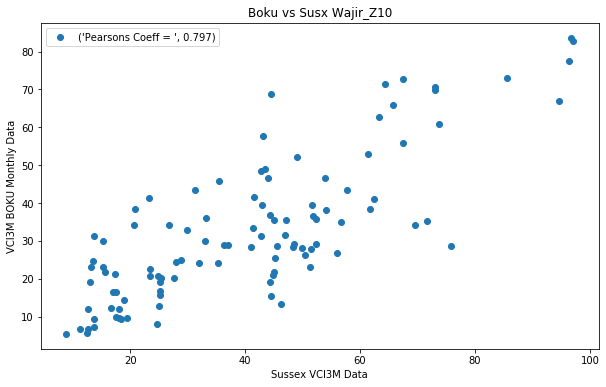

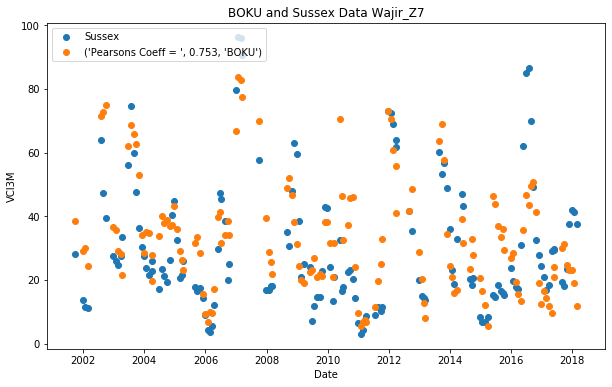

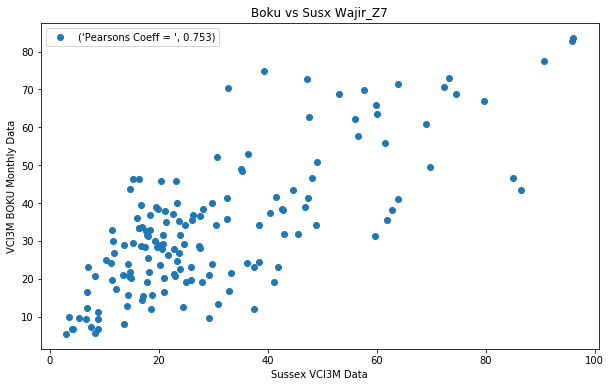

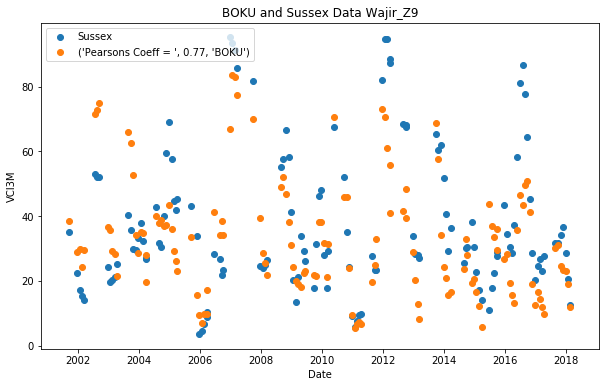

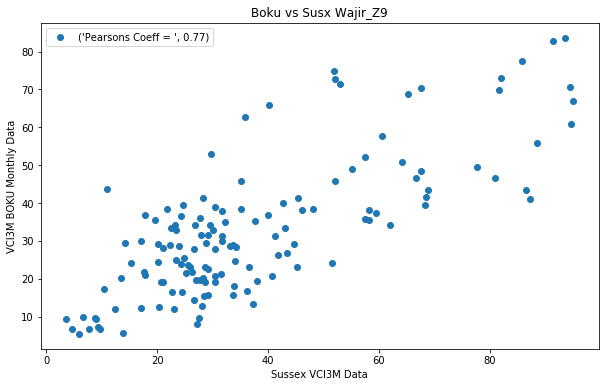

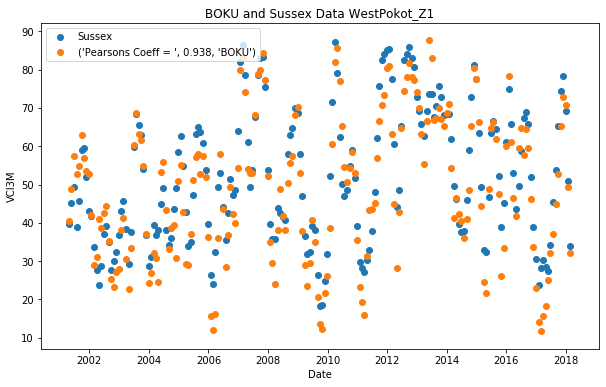

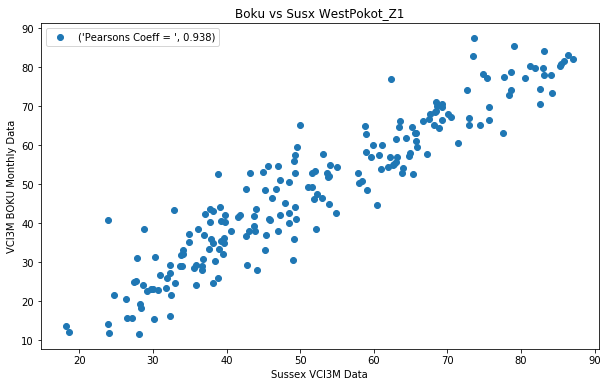

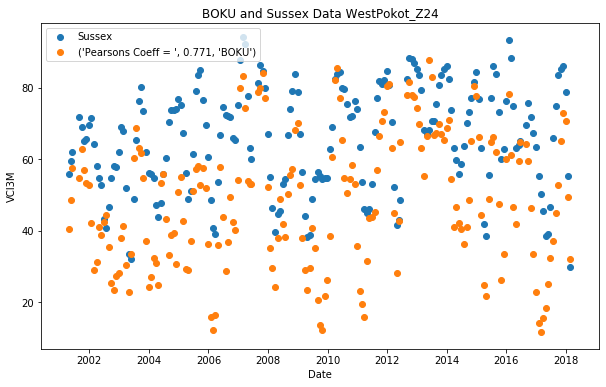

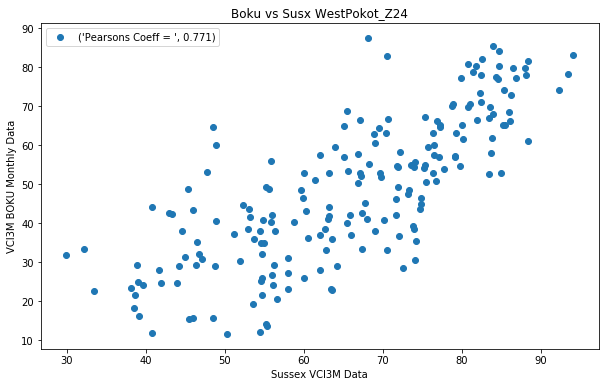

In [13]:
# As BOKU data wasn't in Julian format datetime is needed.

from datetime import date

# Creating empty lists that will be used to store data needed to be displayed later. 

Percent1 = []
Percent2 =[]
Percent3 = []
Percent4 =[]
Regions = []
Pearsons2 = []
BokuMeans = []
SusxMeans = []
stdev = []


# Same as other method, iterate through all npy files.

for file in os.listdir(os.getcwd()+ '/Data/'):
    if file.endswith(".npy"):
        
        # Reading Sussex data from npy files
        
        Name = file.split('_',1)[0]
        MODIS = np.load(os.getcwd()+'/Data/' + file)
        SusxVCI3M= MODIS[2]
        stime = MODIS[0]
        
        #Creating empty lists to help filter out data. 
        
        susxtime = []
        sxvci =[] 
        WeekUnder35 =[]
        dates =[]
        BOKUYEAR = []
        BOKUMONTH = []
        BOKUVCI3M = []
        newdates =[]
        susxvci = []
        
        # Creating list of regions that will be displayed 
        
        Regions.append((file.split('_AR_MODIS',1)[0])+ ' vs '+ Name)
        
        # Matching corrent Sussex data to BOKU data
        
        
        for Loc,year,month,vci in zip(Place,YEAR,MONTH,VCI3M):
            if Loc.upper() == Name.upper():
                BOKUYEAR.append(year)
                BOKUVCI3M.append(vci)
                BOKUMONTH.append(month)
                
                
        # Filtering out any nan data as well as creating a list of Sussex data below 35 vci   
    
        for a,b in zip(SusxVCI3M,stime):
            if np.isnan(a) == False and b >= 456 and b <= 6661 and a <35:
                susxvci.append(a)
                susxtime.append(b)
                WeekUnder35.append(a)
            elif np.isnan(a) == False and b >= 456 and b <= 6661 and a >= 35:
                susxvci.append(a)
                susxtime.append(b)
                
        # Converting Sussex Julian time to python datetime       
                
        d0 = date(2000,1,1)
        [newdates.append(d0 + timedelta(days=item)) for item in susxtime]
        
        
        # The following loop takes the last reading from each month and appends it to a new list.
        
        
        try:
            for counter in range(0,len(newdates)):
                if newdates[counter].month != newdates[counter+1].month:
                    dates.append(newdates[counter])
                    sxvci.append(susxvci[counter])
        except IndexError:
            dates.append(newdates[counter])
            sxvci.append(SusxVCI3M[counter])
            
            
        # More empty lists to be used to filter data   
        
        BOKUfinalMONTH = []
        BOKUfinalYEAR = []
        BOKUfinalVCI =[]
        BOKUfinalDATE = []
        
        # For loop comparing the Sussex and BOKU months and years appending any VCI where the dates match.
        
        for counter,counter2,counter3 in zip(BOKUYEAR,BOKUMONTH,BOKUVCI3M):
            for item in dates:
                if item.month == counter2 and item.year == counter:
                    BOKUfinalDATE.append(date(counter, counter2,item.day))
                    BOKUfinalVCI.append(counter3)
                    
        
        # Deleting final element as this can return nan due to the try except method.
        
        del BOKUfinalVCI[-1]
        del sxvci[-1]
        del dates[-1]
        del BOKUfinalDATE[-1]
        
        

        # Calculating the Pearson coeff between the BOKU and Sussex data. 
        
        Pearson2 = np.corrcoef(BOKUfinalVCI,sxvci)
        Pearson2 = round(Pearson2[0,1],3)
        
        
        # Plotting the Sussex and BOKU data over eachother for easy comparison. Displays Pearson coeff
        
        plt.figure(figsize=(10,6)) 
        plt.title('BOKU and Sussex Data ' + (file.split('_AR_MODIS',1)[0]))  
        plt.xlabel('Date')
        plt.ylabel('VCI3M')
        plt.scatter(dates,sxvci,label='Sussex')
        plt.scatter(np.array(BOKUfinalDATE),np.array(BOKUfinalVCI),label = ('Pearsons Coeff = ', Pearson2,'BOKU'))
        plt.legend(loc='upper left')
        plt.savefig((os.getcwd()+'/pic/BOKUvsSusxTimeSeries'+ file.split('_AR_MODIS',1)[0] +'.png'))
        plt.show()
    
        # Plotting the BOKU and Sussex data against eachother. 

        plt.figure(figsize=(10,6)) 
        plt.title('Boku vs Susx ' + (file.split('_AR_MODIS',1)[0]))
        plt.xlabel('Sussex VCI3M Data')
        plt.ylabel('VCI3M BOKU Monthly Data')
        plt.scatter(sxvci,BOKUfinalVCI,label = ('Pearsons Coeff = ', Pearson2))
        plt.legend(loc='upper left')         
        plt.savefig((os.getcwd()+'/pic/BOKUvsSusx'+ file.split('_AR_MODIS',1)[0] +'.png'))
        plt.plot()
        plt.show()
        
        
        
        # The following if statment allows for the calculation of the fraction that BOKU is in drought when Sussex is.
        # (And vice versa)
        
        BOKUu35counter = 0 
        Susxu35Counter = 0 
        BOKUcounter = 0
        SusxCounter = 0
        
        
        for item1,item2 in zip(BOKUfinalVCI,sxvci):
            if item1 <35:
                BOKUu35counter += 1
                if item2 < 35:
                    Susxu35Counter +=1 
            if item2 <35:
                SusxCounter +=1
                if item1 < 35:
                    BOKUcounter +=1
                    
        # Appending all the individual region data to a list to be saved and displayed later.

        Percent1.append(BOKUu35counter/len(BOKUfinalVCI))
        Percent2.append(Susxu35Counter/BOKUu35counter)
        Percent3.append(SusxCounter/len(sxvci))
        Percent4.append(BOKUcounter/SusxCounter)
        Pearsons2.append(Pearson2)
        BokuMeans.append(np.mean(BOKUfinalVCI))
        SusxMeans.append(np.mean(sxvci))
        stdev.append(np.round(np.std(np.array(BOKUfinalVCI)-np.array(sxvci)),3))
        

### <center> Displaying Comparison Results   </center>

In [5]:
OUT_DIR = (os.getcwd()+'/pic')

# Calculating the difference in means

differences = np.array(BokuMeans)-np.array(SusxMeans)

t = Table([Regions,np.round(Pearsons2,3),np.round(BokuMeans),np.round(SusxMeans,3),
           np.round(differences,3),stdev,np.round(Percent3,3),np.round((np.array(Percent3)*100),3),
           np.round(np.array(Percent1),3),np.round((np.array(Percent1)*100),3),
           np.round((np.array(Percent4)*100),3),np.round((np.array(Percent2)*100),3)], 
          
 names=('Region', 'Pearsons Coeff','BOKU Mean', 'Sussex Mean','Difference In mean(Boku-Sussex)',
        'Standard Dev (BOKU - Sussex)','Fraction Of Time <35 VCI Sussex','Percentage of time Sussex',
        'BOKU Frac Of time <35 VCI','Percentage of time BOKU','Percentage Of BOKU < 35 when Sussex <35',
        'Percentage of time Sussex < 35 when BOKU < 35'), meta={'name': 'NonInterp'})

t.add_row(['Averages',np.round(np.mean(Pearsons2),3),np.round(np.mean(BokuMeans),3),np.round(np.mean(SusxMeans),3),
           np.round(np.mean(differences),3),np.round(np.mean(stdev),3),np.round(np.mean(Percent3),3),
           np.round(np.mean(Percent3)*100,3),np.round(np.mean(Percent1),3),np.round(np.mean(Percent1)*100,3),
           np.round(np.mean(Percent4)*100,3),np.round(np.mean(Percent2)*100,3)])

t.write(("{}/" +'StatisticalTestsNonInterp.csv').format(OUT_DIR), overwrite=True)
t.show_in_notebook()
           

### <center> Comparison of both methods </center>

In [29]:
t=Table([['Averages NonInterp'],[np.round(np.mean(Pearsons2),3)],[np.round(np.mean(BokuMeans),3)],[np.round(np.mean(SusxMeans),3)],
           [np.round(np.mean(differences),3)],[np.round(np.mean(stdev),3)],[np.round(np.mean(Percent3),3)],
           [np.round(np.mean(Percent3)*100,3)],[np.round(np.mean(Percent1),3)],[np.round(np.mean(Percent1)*100,3)],
           [np.round(np.mean(Percent4)*100,3)],[np.round(np.mean(Percent2)*100,3)]], names=('Region', 'Pearsons Coeff','BOKU Interp Mean', 'Sussex Mean','Difference In mean(Boku Interp-Sussex)',
        'Standard Dev (BOKU - Sussex)','Fraction Of Time <35 VCI Sussex','Percentage of time Sussex',
        'BOKU Frac Of time <35 VCI','Percentage of time BOKU','Percentage Of BOKU < 35 when Sussex <35',
        'Percentage of time Sussex < 35 when BOKU < 35'), meta={'name': 'NonInterp'})

t.add_row(['Averages Interp',np.round(np.mean(Pearsons),3),np.round(np.mean(MonthMeans),3),np.round(np.mean(WeekMeans),3),
           np.round(np.mean(difference),3),np.mean(stds),np.round(np.mean(FracWeekUnder35),3),
           np.round(np.mean(FracWeekUnder35)*100,3),np.round(np.mean(FracMonthUnder35),3),
           np.round(np.mean(FracMonthUnder35)*100,3),np.round(np.mean(BokuVsSusxU35)*100,3),
           np.round(np.mean(SusxVsBokuU35)*100,3)])

t.write(("{}/" +'StatisticalTestsComparison.csv').format(OUT_DIR), overwrite=True)
t.show_in_notebook()